# **INTRODUCTION TO DATA SCIENCE**
## Final Projects - House Price Prediction - 22KDL

## **INTRODUCTION**
In the context of an increasingly volatile real estate market, accurate house price prediction is an urgent need. The goal of this project is to build a house price prediction model based on online data, providing users with clear insights and accurate forecasts about real estate values.

## **ABTRACT**
This project aims to develop an accurate house price prediction model using data collected from the website https://batdongsan.vn/ban-nha/. By applying both learned and newly researched data analysis methods and techniques, we evaluated the effectiveness of various predictive models.

## **LITERATURE REVIEW**
Previous studies have employed various methods for house price prediction, ranging from simple regression models to complex machine learning techniques such as Random Forest and Gradient Boosting. This study builds upon and further develops these proven methods.

## **TECH STACKS**

* **Programming Languages:** Python

* **Libraries:** BeautifulSoup, Pandas, Numpy, Matplotlib, Seaborn, Scikit-Learn, Statsmodels,...

* **IDE:** Visual Studio Code, Google Colab, PyCharm

* **Presentation:** Canva

#### **Libraries we used**

In [43]:
import pandas as pd
import numpy as np
import csv
import re
import requests
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV


#### **Presentation**


Link canva: https://www.canva.com/design/DAGIeBSIid4/tt6d9rTssXXQ9mUbg6rlww/edit

## **DATA AND METHODS**

### **Data Collection**

### **Data Preprocessing and Feature Engineering**

Below, our group will report on the issues we encountered during the data preprocessing stage and how we handled them.

#### **Issues encountered during the data processing:**

From the input file (containing raw data crawled from the web), we will perform data preprocessing steps to clean the data, and then output the results into an output file (containing the cleaned data after all preprocessing steps).

In [44]:
# Đường dẫn tới file CSV đầu vào
file_input = '../Data/temp_data.csv'

# Đường dẫn tới file CSV đầu ra
file_output = '../Data/clean_data.csv'

##### **Issue 01:**

When initially crawling data from the web (raw data), I encountered an error that prevented the execution of the `pd.read_csv` command. Upon a preliminary inspection, I discovered that the error was due to extra quotation marks in the data string, which caused the data structure to be incorrect.

In [45]:
# Hàm sửa lỗi dư hoặc thiếu dấu ngoặc kép trong file CSV
def fix_csv_quotes(file_input, file_output):
    # Mở file đầu vào để đọc và file đầu ra để ghi
    with open(file_input, 'r', encoding = 'utf-8') as infile, open(file_output, 'w', newline = '', encoding = 'utf-8') as outfile:
        # Đọc tất cả các dòng từ file đầu vào
        reader = infile.readlines()
        # Tạo writer để ghi vào file đầu ra
        writer = csv.writer(outfile)

        # Lặp qua từng dòng trong file đầu vào
        for line in reader:
            # Kiểm tra số lượng dấu ngoặc kép trong dòng
            num_quotes = line.count('"')
            # Nếu số lượng dấu ngoặc kép là số lẻ, thêm một dấu ngoặc kép ở cuối dòng
            if num_quotes % 2 != 0:
                line = line.strip() + '"\n'
            # Ghi lại dòng đã sửa vào file đầu ra
            writer.writerow(next(csv.reader([line], skipinitialspace = True)))


Use the `fix_csv_quotes` function to appropriately adjust the pairs of quotation marks (" ") in the data.

In [46]:
fix_csv_quotes(file_input, file_output)

##### **Issue 02:**

The data in the columns of the CSV file is not clean; specifically, there are unnecessary characters and special characters that could significantly impact subsequent processes.

In [47]:
column_name = 'Description'  # Tên của cột cần làm sạch

def clean_string(string):
    """
    Hàm này sẽ làm sạch chuỗi bằng cách loại bỏ các biểu tượng và ký tự không cần thiết.
    (nhưng giữ lại các kí tự chữ (hoa và thường), số, dấu chấm, dấu phẩy, dấu | )

    string: Chuỗi cần làm sạch.
    cleanString: Chuỗi đã được làm sạch.
    """
    # Hàm isinstance check xem data input của mình có phải là string không
    if isinstance(string, str):
        cleanString = re.sub(r'[^\w\s.,|]', '', string)  # Xoá tất cả các kí tự ngoại trừ chữ (thường, hoa), số, dấu chấm, dấu phẩy, dấu |
        return cleanString
    else:
        return string

In [48]:
def clean_file_csv(file_input, file_output, column_name):
    """
    Hàm này sẽ làm sạch một cột cụ thể trong file CSV.

    input_csv (str): Đường dẫn tới file CSV đầu vào (temp_data).
    output_csv (str): Đường dẫn tới file CSV đầu ra (clean_data).
    column_name (str): Tên của cột cần làm sạch.
    """
    # Đọc file CSV vào DataFrame
    df = pd.read_csv(file_input, on_bad_lines = 'skip')

    # Kiểm tra xem tên cột có hợp lệ không
    if column_name in df.columns:
        # Áp dụng hàm làm sạch cho cột cụ thể
        df[column_name] = df[column_name].apply(clean_string)
    else:
        print(f"Invalid column name: {column_name}")

    # Lưu lại DataFrame đã được làm sạch thành file CSV mới
    df.to_csv(file_output, index = False)

In [49]:
# Gọi hàm để làm sạch cột
clean_file_csv(file_input, file_output, column_name)

##### **Issue 03:**

Extract data from the **`Title`** and **`Description`** fields to fill in the positions where the data is null using `regular expressions` (regex).

In [50]:
# Đọc lại file csv, xoá các dòng bị lỗi
# (mình nhận thấy số lượng dòng bị lỗi không nhiều ~ 10 dòng nên mình sẽ skip luôn vì tụi mình có nhiều data mà =))))
df = pd.read_csv('../Data/clean_data.csv', on_bad_lines = 'skip')

In [51]:
# Thay thế "Thoả thuận" bằng NaN cho dễ xử lí về sau (tạm thời)
df['Price'] = df['Price'].replace('TT', np.nan)

In [52]:
# Biểu thức chính quy để trích xuất thông tin giá
price_pattern = re.compile(
    r'Giá[^0-9]*([0-9]+[.,]?[0-9]*)\s*(Tỷ|Triệu)',
    re.IGNORECASE
)
# 'Giá' - Tìm từ "Giá"
# '[^0-9]*' - Không chứa ký tự số
# '([0-9]+[.,]?[0-9]*)' - Nhóm các số, có thể có dấu phẩy hoặc dấu chấm
# '\s*' - Bỏ qua các khoảng trắng
# '(Tỷ|Triệu)' - Tìm từ "Tỷ" hoặc "Triệu"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường


# Biểu thức chính quy để trích xuất thông tin diện tích
area_pattern = re.compile(
    r'(\d+\.?\d*)\s*x\s*(\d+\.?\d*)|\((\d+\.?\d*)m2\)',
    re.IGNORECASE
)
# '(\d+\.?\d*)\s*x\s*(\d+\.?\d*)' - Tìm diện tích dưới dạng "chiều dài x chiều rộng"
# '(\d+\.?\d*)' - Nhóm tìm các số, có thể có dấu chấm thập phân
# '\s*x\s*' - Tìm ký tự "x", có thể có khoảng trắng
# '(\d+\.?\d*)' - Nhóm tìm các số phía sau ký tự "x"
# '|' - Hoặc
# '\((\d+\.?\d*)m2\)' - Tìm diện tích dưới dạng "(xxx m2)"
# '\(' - Dấu mở ngoặc đơn
# '(\d+\.?\d*)' - Nhóm tìm các số, có thể có dấu chấm thập phân
# 'm2' - Ký tự "m2"
# '\)' - Dấu đóng ngoặc đơn
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường


# Biểu thức chính quy để trích xuất thông tin số phòng ngủ
bedroom_pattern = re.compile(
    r'(\d+)\s*PN',
    re.IGNORECASE
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# 'PN' - Tìm từ "PN" (phòng ngủ)
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường


# Biểu thức chính quy để trích xuất thông tin số nhà vệ sinh
wc_pattern = re.compile(
    r'(\d+)\s*WC',
    re.IGNORECASE
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# 'WC' - Tìm từ "WC" (nhà vệ sinh)
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường


# Biểu thức chính quy để trích xuất thông tin số tầng
floor_pattern = re.compile(
    r'(\d+)\s*(lầu|tầng|tang|tâng|lau|lâu|sàn lầu)',
    re.IGNORECASE
)
# '(\d+)' - Nhóm tìm một hoặc nhiều chữ số
# '\s*' - Bỏ qua các khoảng trắng
# '(lầu|tầng)' - Tìm từ "lầu" hoặc "tầng"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường


# Biểu thức chính quy để trích xuất thông tin pháp lý của ngôi nhà
legal_pattern = re.compile(
    r'\b(pháp lý|sổ|so hong|phap ly)\b',
    re.IGNORECASE)
#\b: Ký tự biên (word boundary), đảm bảo rằng từ được tìm kiếm là từ độc lập, không phải là một phần của từ khác.
#(pháp lý|sổ): Nhóm các từ cần tìm kiếm, cụ thể là "sổ", "pháp lý", "sổ hồng"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường


# Biểu thức chính quy để trích xuất thông tin xem nhà ở mặt tiền hay hẻm
frontage_pattern = re.compile(r'\b(mặt tiền|hẻm|mat tien|hem)\b', re.IGNORECASE)
#\b: Ký tự biên (word boundary), đảm bảo rằng từ được tìm kiếm là từ độc lập, không phải là một phần của từ khác.
#(pmặt tiền|hẻm|mat tien|hem): Nhóm các từ cần tìm kiếm, cụ thể là "mặt tiền", ""hẻm"
# 're.IGNORECASE' - Không phân biệt chữ hoa chữ thường

In [53]:
# Hàm để kiểm tra xem một câu có chứa các cụm từ "xây được", "xây", "được xây" hay không
# Do các thông tin nay gây trích xuất sai: Khu vực xây được ... tầng không phải là số tầng của căn nhà
def contains_build_phrase(text):
    return bool(re.search(r'\b(xây được|xây|được xây)\b', text, re.IGNORECASE))

In [54]:
# Hàm để loại bỏ các số sau cụm từ "xây được", "xây", "được xây"
def remove_numbers(text):
    pattern = re.compile(r'\b(xây được|xây|được xây)\b.*?(\d+)', re.IGNORECASE)
    return pattern.sub(r'\1', text)

In [55]:
# Hàm để xử lý các trường hợp đặc biệt như "1 trệt 1 lầu", "1 trệt 1 lửng"
def special_cases(text):
    if re.search(r'\b1 trệt 1 lầu\b', text, re.IGNORECASE):
        return 2
    if re.search(r'\b1 trệt 1 lửng\b', text, re.IGNORECASE):
        return 1
    return None

In [56]:
# Hàm để trích xuất thông tin từ một chuỗi văn bản
def extract_info(text):
    # Kiểm tra nếu text là None hoặc NaN thì gán giá trị rỗng
    if text is None or pd.isna(text):
        text = ''  # Khởi tạo giá trị rỗng nếu text là None hoặc NaN
    # Nếu text không phải là chuỗi, chuyển đổi nó sang chuỗi
    elif not isinstance(text, str):
        text = str(text)  # Chuyển đổi giá trị sang chuỗi nếu không phải là chuỗi

    # Loại bỏ các số sau cụm từ "xây được", "xây", "được xây"
    filtered_text = remove_numbers(text)

    # Kiểm tra các trường hợp đặc biệt
    floors = special_cases(filtered_text)

    # Nếu không có trường hợp đặc biệt, tiếp tục trích xuất thông tin thông thường
    if floors is None:
        # Tìm kiếm các mẫu trong text
        price_match = price_pattern.search(filtered_text)
        area_match = area_pattern.search(filtered_text)
        bedroom_match = bedroom_pattern.search(filtered_text)
        wc_match = wc_pattern.search(filtered_text)
        legal_match = legal_pattern.search(filtered_text)
        frontage_match = frontage_pattern.search(filtered_text)

        # Trích xuất số tầng nếu tìm thấy
        floor_matches = floor_pattern.findall(filtered_text)
        if floor_matches:
            for match in floor_matches:
                floor_count = int(match[0])
                if match[1].lower() in ['lầu', 'lau', 'lâu', 'sàn lầu']:
                    floors = floor_count + 1  # Tăng giá trị lên 1 nếu là "lầu"
                    break
                elif match[1].lower() in ['tầng', 'tang', 'tâng']:
                    if floor_count > 15:
                        lầu_match = re.search(r'(\d+)\s*(lầu|lau|lâu|sàn lầu)', filtered_text, re.IGNORECASE)
                        if lầu_match:
                            floors = int(lầu_match.group(1)) + 1
                            break
                    else:
                        floors = floor_count

        price = None
        # Nếu tìm thấy giá
        if price_match:
            number = price_match.group(1).replace(',', '.')
            unit = price_match.group(2)
            # Chuyển đổi giá trị sang VND dựa trên đơn vị
            if unit and unit.lower() in ['tỷ', 'tỷ', 'tỉ']:
                price = float(number) * 1_000_000_000  # Chuyển đổi tỷ sang VND
            elif unit and unit.lower() in ['triệu', 'triệu']:
                price = float(number) * 1_000_000  # Chuyển đổi triệu sang VND
            else:
                price = float(number)  # Nếu không có đơn vị, chỉ trả về số dưới dạng float

        area = None
        # Nếu tìm thấy diện tích
        if area_match:
            if area_match.group(3):
                area = float(area_match.group(3))  # Diện tích tổng (150m2)
            else:
                width = float(area_match.group(1))
                length = float(area_match.group(2))
                area = width * length  # Tính diện tích từ chiều dài và chiều rộng

        # Trích xuất số phòng ngủ nếu tìm thấy
        bedrooms = bedroom_match.group(1) if bedroom_match else None
        # Trích xuất số nhà vệ sinh nếu tìm thấy
        wcs = wc_match.group(1) if wc_match else None
        legal = 1 if legal_match else None
        frontage = 1 if frontage_match and frontage_match.group(0).lower() in ['mặt tiền', 'mat tien'] else 0 if frontage_match and frontage_match.group(0).lower() in ['hẻm', 'hem'] else None
    else:
        # Gán giá trị mặc định cho các thông tin khác nếu không có thông tin từ văn bản
        price = None
        area = None
        bedrooms = None
        wcs = None
        legal = None
        frontage = None

    # Trả về kết quả dưới dạng Series của pandas
    return pd.Series([price, area, bedrooms, wcs, floors, legal, frontage])


In [57]:
# Hàm để trích xuất thông tin từ cả 'Title' và 'Description'
def extract_info_from_row(row):
    title_info = extract_info(row['Title'])
    description_info = extract_info(row['Description'])

    # Nếu thông tin từ Description không có, lấy thông tin từ Title
    final_info = title_info.combine_first(description_info)

    return final_info


In [58]:
if 'Floors' not in df.columns:
    df['Floors'] = None
if 'Legal_status' not in df.columns:
    df['Legal_status'] = None
if 'Frontage' not in df.columns:
    df['Frontage'] = None

In [59]:
# Áp dụng hàm extract_info_from_row lên từng hàng của DataFrame và lưu kết quả vào các cột mới
df[['Extracted_Price', 'Extracted_Area', 'Extracted_Bedrooms', 'Extracted_WCs', 'Extracted_Floors', 'Extracted_Legal_status', 'Extracted_Frontage']] = df.apply(extract_info_from_row, axis = 1)

# Chuyển đổi cột 'Price' sang kiểu số, nếu có lỗi thì gán giá trị NaN
df['Price'] = pd.to_numeric(df['Price'], errors ='coerce')

# Cập nhật cột 'Price' theo điều kiện: nếu 'Price' ban đầu là NaN hoặc lớn hơn 1000 thì lấy giá trị từ 'Extracted_Price'
df['Price'] = df.apply(lambda row: row['Extracted_Price'] if pd.isnull(row['Price']) or row['Price'] > 1000 else row['Price'], axis = 1)

# Hàm để điền thông tin số phòng ngủ (bedrooms), số nhà vệ sinh (WCs) và số tầng (floors) từ các giá trị đã trích xuất
def fill_info(row):
    if pd.isnull(row['Bedrooms']):
        row['Bedrooms'] = row['Extracted_Bedrooms']  # Nếu 'Bedrooms' ban đầu là NaN thì lấy giá trị từ 'Extracted_Bedrooms'
    if pd.isnull(row['WCs']):
        row['WCs'] = row['Extracted_WCs']  # Nếu 'WCs' ban đầu là NaN thì lấy giá trị từ 'Extracted_WCs'
    if pd.isnull(row['Floors']):
        row['Floors'] = row['Extracted_Floors']  # Nếu 'Floors' ban đầu là NaN thì lấy giá trị từ 'Extracted_Floors'
    if pd.isnull(row['Legal_status']):
        row['Legal_status'] = row['Extracted_Legal_status']  # Nếu 'Legal_status' ban đầu là NaN thì lấy giá trị từ 'Extracted_Legal_status'
    if pd.isnull(row['Frontage']):
        row['Frontage'] = row['Extracted_Frontage']  # Nếu 'Frontage' ban đầu là NaN thì lấy giá trị từ 'Extracted_Frontage'

    return row


C:\Users\Admin\AppData\Local\Temp\ipykernel_15220\1534068129.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_info = title_info.combine_first(description_info)


In [60]:
# Áp dụng hàm fill_info lên từng hàng của DataFrame
df = df.apply(fill_info, axis = 1)

# Xuất DataFrame mới ra file CSV
df.to_csv(file_output, index = False)

In [61]:
print(df.head())

   No  Price                                              Title  Area  \
0   1    NaN  Cửa gỗ công nghiệp MDF laminate cao cấp tại Qu...   NaN   
1   2    NaN   ��The power of online advertising facebook ads��   NaN   
2   3    NaN  ��️ Email/SMS Marketing - Sustainable communic...   NaN   
3   4   13.5  Siêu rẻ ! Nhà 1 Đời Chủ, 2 MT Hoàng Sa, Q1, Đo...  44.0   
4   5    NaN  Maxads - leading the trend of MULTIMEDIA ADVER...   NaN   

  Bedrooms   WCs District             Postdate  \
0      NaN   NaN   quan-1  2023-11-22 11:08:20   
1     None  None   quan-1  2023-11-23 10:27:56   
2     None  None   quan-1  2023-11-24 09:44:58   
3      NaN   NaN   quan-1  2023-11-24 16:39:03   
4     None  None   quan-1  2023-11-25 09:55:56   

                                         Description  Floors  Legal_status  \
0   |HOTLINE  zalo 035.312.6411  0888.696.029 NVK...     NaN           NaN   
1  advertising forms quotas a springboardquot bec...     NaN           NaN   
2  interaction strategy. C

In [62]:
# Loại bỏ cột No và cột Title không cần thiết
cols_drop = ['No', 'Title']
df = df.drop(columns = cols_drop)

In [63]:
print(df)

             Price   Area Bedrooms  WCs District             Postdate  \
0              NaN    NaN      NaN  NaN   quan-1  2023-11-22 11:08:20   
1              NaN    NaN      NaN  NaN   quan-1  2023-11-23 10:27:56   
2              NaN    NaN      NaN  NaN   quan-1  2023-11-24 09:44:58   
3     1.350000e+01   44.0      NaN  NaN   quan-1  2023-11-24 16:39:03   
4              NaN    NaN      NaN  NaN   quan-1  2023-11-25 09:55:56   
...            ...    ...      ...  ...      ...                  ...   
9979  7.000000e+00  170.0      NaN  NaN  thu-duc  2022-10-27 16:24:29   
9980  3.300000e+00   40.0      4.0  2.0  thu-duc  2022-10-27 14:48:46   
9981  1.300000e+01   52.8      4.0  5.0  thu-duc  2022-10-27 09:36:50   
9982  5.600000e+09  112.0      3.0  2.0  thu-duc  2022-10-26 22:29:32   
9983  6.000000e+00  100.0      NaN  NaN  thu-duc  2022-10-25 13:03:53   

                                            Description  Floors  Legal_status  \
0      |HOTLINE  zalo 035.312.6411  0888.6

##### **Issue 04:**

Perform detailed processing, calculations, and filling of missing values. Additionally, add a feature called **`Price_per_sqm`** (price per square meter).

In [64]:
# Chuyển đổi các cột 'Price' và 'Area' sang kiểu số (float) để thực hiện các bước xử lí, tính toán dễ dàng hơn.
df['Price'] = df['Price'].astype(float)
df['Area'] = df['Area'].astype(float)

In [65]:
# Chuyển đổi các cột 'Price' và 'Area' sang kiểu số (float) để thực hiện các bước xử lí, tính toán dễ dàng hơn.
df['Price'] = df['Price'].astype(float)
df['Area'] = df['Area'].astype(float)

# Hàm xử lý cột Price
def process_price(df):
    def convert_price(price):
        if pd.isnull(price):
            return price
        price = float(price)
        if price > 1e9:
            return price / 1e9  # Nếu giá trị lớn hơn 1 tỷ, chuyển sang đơn vị tỷ
        elif price > 1e6:
            return price / 1e6  # Nếu giá trị lớn hơn 1 triệu, chuyển sang đơn vị triệu
        elif price > 1e3:
            return price / 1e3  # Nếu giá trị lớn hơn 1 nghìn, chuyển sang đơn vị nghìn
        return price  # Trả về giá trị gốc nếu nhỏ hơn 1 nghìn

    df['Price'] = df['Price'].apply(convert_price)  # Áp dụng hàm convert_price cho cột 'Price'
    return df

df = process_price(df)

# Hàm tính giá trên một mét vuông
def price_per_sqm(df):
    df['Price_per_sqm'] = df.apply(lambda row: row['Price'] / row['Area'] if pd.notnull(row['Price']) and pd.notnull(row['Area']) else np.nan, axis=1)
    return df
# Thêm cột giá trên 1 mét vuông
df = price_per_sqm(df)

# Tính price_per_sqm trung bình theo từng quận
district_price_per_sqm = df.groupby('District')['Price_per_sqm'].mean(numeric_only=True)  # fix

# Hàm điền giá trị thiếu
def fill_miss_vals(df):
    # Tính giá trị trung bình của 'Price', 'Area' theo 'District'
    district_means = df.groupby('District').mean(numeric_only=True)

    # Điền giá trị thiếu cho 'Price' và 'Area' dựa trên 'Price_per_sqm' trung bình của quận
    for idx, row in df.iterrows():  # fix
        if pd.isnull(row['Price']) and pd.notnull(row['Area']):  # fix
            df.at[idx, 'Price'] = row['Area'] * district_price_per_sqm[row['District']]  # fix
        elif pd.isnull(row['Area']) and pd.notnull(row['Price']):  # fix
            df.at[idx, 'Area'] = row['Price'] / district_price_per_sqm[row['District']]  # fix

    # Làm tròn các giá trị vừa điền vào
    df['Price'] = df['Price'].round(2)
    df['Area'] = df['Area'].round(2)
    df['Price_per_sqm'] = df['Price_per_sqm'].round(2)

    return df

# Thêm cột giá trên 1 mét vuông
df = price_per_sqm(df)

# Điền giá trị thiếu cho 'Price' và 'Area'
df = fill_miss_vals(df)

# Thực hiện xử lí các giá trị ở cột Price để dữ liệu chuẩn hơn, hợp lý hơn.
df = process_price(df)

# Kiểm tra giá trị null trong cột 'Area' và 'Price'
null_area = df['Area'].isnull().sum()
null_price = df['Price'].isnull().sum()

print(f"Null Area: {null_area}")
print(f"Null Price: {null_price}")

df.head()  # Hiển thị dữ liệu sau khi xử lý

Null Area: 315
Null Price: 315


,Price,Area,Bedrooms,WCs,District,Postdate,Description,Floors,Legal_status,Frontage,Extracted_Price,Extracted_Area,Extracted_Bedrooms,Extracted_WCs,Extracted_Floors,Extracted_Legal_status,Extracted_Frontage,Price_per_sqm
0,NaN,NaN,NaN,NaN,quan-1,2023-11-22 11:08:20,|HOTLINE zalo 035.312.6411 0888.696.029 NVK...,NaN,NaN,NaN,NaN,4950.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,None,None,quan-1,2023-11-23 10:27:56,advertising forms quotas a springboardquot bec...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
2,NaN,NaN,None,None,quan-1,2023-11-24 09:44:58,interaction strategy. Connect and build a clos...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN
3,13.5,44.0,NaN,NaN,quan-1,2023-11-24 16:39:03,"Chủ kẹt cần bán gấp nhà 2 MT Hoàng Sa, Phường ...",5.0,NaN,1.0,1.350000e+10,44.0,NaN,NaN,5.0,NaN,1.0,0.31
4,NaN,NaN,None,None,quan-1,2023-11-25 09:55:56,Youtube Ads is a form of advertising that hel...,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN


In [66]:
# Kiểm tra giá trị null trong cột 'Area' và 'Price'
null_area = df['Area'].isnull().sum()
print(null_area)
null_price = df['Price'].isnull().sum()
print(null_price)

315
315


For the purpose of discarding unreasonable data.

In [67]:
'''
# Hàm để cập nhật cột Price theo điều kiện price_per_sqm > 1
def update_price(row):
    # Kiểm tra nếu 'Area' không phải là None và lớn hơn 0
    if row['Area'] and row['Area'] > 0:  # Đảm bảo diện tích không phải là None hoặc 0
        # Tính giá trên mỗi mét vuông
        price_per_sqm = row['Price'] / row['Area']
        # Nếu giá trên mỗi mét vuông lớn hơn 1
        if price_per_sqm > 1:
            # Trả về giá trị từ 'Extracted_Price'
            return row['Extracted_Price']
    # Nếu không thỏa mãn điều kiện, trả về giá trị ban đầu của 'Price'
    return row['Price']

# Áp dụng hàm update_price lên từng hàng của DataFrame
df['Price'] = df.apply(update_price, axis = 1)'''

"\n# Hàm để cập nhật cột Price theo điều kiện price_per_sqm > 1\ndef update_price(row):\n    # Kiểm tra nếu 'Area' không phải là None và lớn hơn 0\n    if row['Area'] and row['Area'] > 0:  # Đảm bảo diện tích không phải là None hoặc 0\n        # Tính giá trên mỗi mét vuông\n        price_per_sqm = row['Price'] / row['Area']\n        # Nếu giá trên mỗi mét vuông lớn hơn 1\n        if price_per_sqm > 1:\n            # Trả về giá trị từ 'Extracted_Price'\n            return row['Extracted_Price']\n    # Nếu không thỏa mãn điều kiện, trả về giá trị ban đầu của 'Price'\n    return row['Price']\n\n# Áp dụng hàm update_price lên từng hàng của DataFrame\ndf['Price'] = df.apply(update_price, axis = 1)"

##### **Issue 05:**

The next issue with the data is that there are too many duplicate rows.

Initially, after using Python's built-in command to remove duplicates `drop_duplicates()` (removing rows that are 100% identical), I realized that many duplicates still remained due to the following reasons:
* The same house was posted multiple times with different descriptions.
* The same house was posted at different times or on different dates.
* ...

These reasons caused the duplicates not to be completely removed, as Python's built-in function only deletes rows that are 100% identical. Since the **`Postdate`** and **`Description`** fields had slight differences, the built-in function `drop_duplicates()` could not effectively handle this.

The following tasks we handled focused on the **`Postdate`** and **`Description`**

In [68]:
# Xử lí cột Postdate (chỉ giữ lại Ngày xoá Giờ)
# Chuyển đổi cột 'Postdate' sang kiểu datetime
df['Postdate'] = pd.to_datetime(df['Postdate'])

# Tạo một cột mới chỉ chứa ngày
df['Date'] = df['Postdate'].dt.date

# Tìm vị trí (index) của cột 'Postdate'
col_index = df.columns.get_loc('Postdate')

# Xóa cột 'Postdate' cũ
df = df.drop(columns = ['Postdate'])

# Chèn cột 'Date' mới vào đúng vị trí cũ của cột 'Postdate'
df.insert(col_index, 'Postdate', df.pop('Date'))

In [69]:
# Load lại những thay đổi vào file clean_data.csv
df.to_csv(file_output, index = False)

At this point, after running the program, an additional error appeared (Unusual line terminators). After some research, we found a solution using the `remove_unusual_line_terminators` function.

In [70]:
def remove_unusual_line_terminators(file_input, file_output):
    with open(file_input, 'r', encoding='utf-8') as infile:
        content = infile.read()

    # Loại bỏ các ký tự kết thúc dòng không bình thường (LS và PS)
    cleaned_content = content.replace('\u2028', '\n').replace('\u2029', '\n')

    with open(file_output, 'w', encoding='utf-8', newline='') as outfile:
        outfile.write(cleaned_content)

Remove all duplicate rows.

In [71]:
def remove_duplicates(df):
    # Đảm bảo rằng các giá trị trong 'Postdate' và 'Description' là chuỗi
    df['Postdate'] = df['Postdate'].astype(str)
    df['Description'] = df['Description'].astype(str)

    # Bước 1: Loại bỏ các dòng trùng lặp mà tất cả các cột đều giống nhau
    df = df.drop_duplicates()

    # Bước 2: Nhóm các dòng theo các cột 'Price', 'Area', 'Bedrooms', 'WCs', 'District'
    grouped = df.groupby(['Price', 'Area', 'Bedrooms', 'WCs', 'District'], dropna = False)

    # Danh sách các chỉ số của các dòng cần giữ lại
    indices_to_keep = set(df.index)

    def similar(a, b):
        return SequenceMatcher(None, a, b).ratio()

    # Lặp qua từng nhóm để kiểm tra sự tương đồng
    for _, group in grouped:
        group_indices = list(group.index)
        for i in range(len(group_indices)):
            for j in range(i + 1, len(group_indices)):
                idx1, idx2 = group_indices[i], group_indices[j]
                row1, row2 = df.loc[idx1], df.loc[idx2]
                # Kiểm tra sự tương đồng của 'Description' và ngày 'Postdate'
                postdate_similarity = similar(row1['Postdate'], row2['Postdate'])
                description_similarity = similar(row1['Description'], row2['Description'])
                if postdate_similarity > 0.75 and description_similarity > 0.5:
                    indices_to_keep.discard(idx2)

    # Chuyển đổi tập hợp các chỉ số cần giữ lại thành danh sách
    indices_to_keep = list(indices_to_keep)

    # Lọc lại DataFrame với các chỉ số cần giữ lại
    df_cleaned = df.loc[indices_to_keep].reset_index(drop = True)

    # Trả về DataFrame đã loại bỏ các dòng trùng lặp
    return df_cleaned


In [72]:
# Áp dụng hàm remove_duplicates lên DataFrame đã được làm sạch
df = remove_duplicates(df)

In [73]:
# Check for missing values in the dataset
print(df.isnull().sum())

Price                      258
Area                       258
Bedrooms                  2544
WCs                       2871
District                     0
Postdate                     0
Description                  0
Floors                    1995
Legal_status              3968
Frontage                  2834
Extracted_Price           5338
Extracted_Area            5661
Extracted_Bedrooms        6232
Extracted_WCs             6090
Extracted_Floors          1995
Extracted_Legal_status    3968
Extracted_Frontage        2834
Price_per_sqm             1237
dtype: int64


##### **Issue 06:**

Old posts can cause inaccuracies with the current timeframe, so we decided to delete outdated data (specifically, house sale posts from 2022).

In [74]:
# Xem kiểu dữ liệu của cột "Postdate"
df['Postdate'].dtype

dtype('O')

In [75]:
# Chuyển kiểu dữ liệu của cột "Postdate" sang dạng datetime và check lại kiểu dữ liệu 1 lần nữa
df['Postdate'] = pd.to_datetime(df['Postdate'])
df['Postdate'].dtype

dtype('<M8[ns]')

In [76]:
# Loại bỏ các data có ngày đăng tin là 2022 và lưu lại vào file csv
df = df[df['Postdate'].dt.year != 2022]

In [77]:
# Check for missing values in the dataset
print(df.isnull().sum())

Price                      230
Area                       230
Bedrooms                  2057
WCs                       2361
District                     0
Postdate                     0
Description                  0
Floors                    1573
Legal_status              3054
Frontage                  2204
Extracted_Price           4204
Extracted_Area            4454
Extracted_Bedrooms        4920
Extracted_WCs             4819
Extracted_Floors          1573
Extracted_Legal_status    3054
Extracted_Frontage        2204
Price_per_sqm             1042
dtype: int64


##### **Issue 07:**

After the above data processing steps, upon re-evaluating the data, we noticed that some data entries were still unreasonable. Therefore, we proceeded to delete these unreasonable data entries.

In [78]:
def remove_invalid(df):
    return df[(df['Price_per_sqm'] <= 2) & (df['Price_per_sqm'] >= 0.03)]

# Áp dụng hàm để loại bỏ các hàng không hợp lệ
df = remove_invalid(df)



In [79]:
# Check for missing values in the dataset
print(df.isnull().sum())

Price                        0
Area                         0
Bedrooms                  1477
WCs                       1748
District                     0
Postdate                     0
Description                  0
Floors                    1205
Legal_status              2461
Frontage                  1725
Extracted_Price           3314
Extracted_Area            3636
Extracted_Bedrooms        4025
Extracted_WCs             3902
Extracted_Floors          1205
Extracted_Legal_status    2461
Extracted_Frontage        1725
Price_per_sqm                0
dtype: int64


In [80]:
print(df.describe())

             Price         Area                       Postdate       Floors  \
count  5712.000000  5712.000000                           5712  4507.000000   
mean     10.269662    79.460011  2023-06-30 11:39:19.663865856     3.219880   
min       1.200000     5.000000            2023-01-01 00:00:00     1.000000   
25%       4.250000    45.000000            2023-04-05 00:00:00     2.000000   
50%       5.800000    60.000000            2023-07-09 00:00:00     3.000000   
75%       9.000000    84.250000            2023-09-22 00:00:00     4.000000   
max     530.000000  2035.000000            2023-12-10 00:00:00    13.000000   
std      21.809202    87.287698                            NaN     1.253765   

       Legal_status     Frontage  Extracted_Price  Extracted_Area  \
count        3251.0  3987.000000     2.398000e+03     2076.000000   
mean            1.0     0.360923     1.199115e+10      271.279981   
min             1.0     0.000000     1.960000e+06        0.000000   
25%         

We noticed that house prices were not reasonable in some areas, so we adjusted the prices to be more accurate.

In [81]:
# Danh sách các quận cần điều chỉnh
districts = ['binh-chanh', 'binh-tan', 'hoc-mon', 'cu-chi', 'tan-binh', 'quan-8', 'quan-12']

def adjust_price(row):
    if any(district in row['District'] for district in districts) and row['Price_per_sqm'] > 1:
        return row['Price'] / 1_000
    return row['Price']

# Áp dụng hàm adjust_price_for_district
df['Price'] = df.apply(adjust_price, axis = 1)


In [82]:
# Check for missing values in the dataset
print(df.isnull().sum())

Price                        0
Area                         0
Bedrooms                  1477
WCs                       1748
District                     0
Postdate                     0
Description                  0
Floors                    1205
Legal_status              2461
Frontage                  1725
Extracted_Price           3314
Extracted_Area            3636
Extracted_Bedrooms        4025
Extracted_WCs             3902
Extracted_Floors          1205
Extracted_Legal_status    2461
Extracted_Frontage        1725
Price_per_sqm                0
dtype: int64


In [83]:
cols_drop = ['Extracted_Price', 'Extracted_Area', 'Extracted_Bedrooms', 'Extracted_WCs', 'Extracted_Floors', 'Extracted_Legal_status','Extracted_Frontage']
# Xóa các cột
df = df.drop(columns = cols_drop)

In [84]:
# Lưu lại DataFrame vào file CSV
df.to_csv(file_output, index = False)

In [85]:
# Check for missing values in the dataset
print(df.isnull().sum())

Price               0
Area                0
Bedrooms         1477
WCs              1748
District            0
Postdate            0
Description         0
Floors           1205
Legal_status     2461
Frontage         1725
Price_per_sqm       0
dtype: int64


##### **Issue 08:**

Encode the **`District`** column into numerical values and extract the month from the **`Postdate`** column.

In [86]:
# Encode cột District
# Đầu tiên, xác định các giá trị duy nhất trong cột District
district_unique_values = df['District'].unique()

# Tạo một ánh xạ từ tên quận thành các giá trị số
district_mapping = {district: i for i, district in enumerate(district_unique_values)}

# Áp dụng ánh xạ vào cột District
df['District_encoded'] = df['District'].map(district_mapping)

# Encode cột Postdate thành tháng
df['Month'] = df['Postdate'].dt.month
# Loại bỏ các cột 'Description' và 'Postdate' khỏi DataFrame
df = df.drop(columns=['Description', 'Postdate'])

# Kiểm tra lại DataFrame sau khi loại bỏ cột
print(df.head())


   Price   Area Bedrooms  WCs District  Floors  Legal_status  Frontage  \
3   13.5   44.0      NaN  NaN   quan-1     5.0           NaN       1.0   
6    8.7   45.0      3.0  3.0   quan-1     4.0           1.0       0.0   
7   21.5   64.0      NaN  NaN   quan-1     NaN           1.0       1.0   
8    9.3   40.0      4.0  4.0   quan-1     4.0           1.0       0.0   
9  130.0  455.0      NaN  NaN   quan-1    13.0           NaN       1.0   

   Price_per_sqm  District_encoded  Month  
3           0.31                 0     11  
6           0.19                 0     11  
7           0.34                 0     11  
8           0.23                 0     11  
9           0.29                 0     10  


In [87]:
# Hiển thị thống kê mô tả cho các cột số
print(df.describe())

             Price         Area       Floors  Legal_status     Frontage  \
count  5712.000000  5712.000000  4507.000000        3251.0  3987.000000   
mean     10.143388    79.460011     3.219880           1.0     0.360923   
std      20.627433    87.287698     1.253765           0.0     0.480328   
min       0.066000     5.000000     1.000000           1.0     0.000000   
25%       4.250000    45.000000     2.000000           1.0     0.000000   
50%       5.800000    60.000000     3.000000           1.0     0.000000   
75%       9.000000    84.250000     4.000000           1.0     1.000000   
max     510.000000  2035.000000    13.000000           1.0     1.000000   

       Price_per_sqm  District_encoded        Month  
count    5712.000000       5712.000000  5712.000000  
mean        0.125849         14.653887     6.476541  
std         0.125141          6.222636     3.109986  
min         0.030000          0.000000     1.000000  
25%         0.080000         11.000000     4.000000  


In [88]:
# Hiển thị số lượng giá trị thiếu cho mỗi cột
print(df.isnull().sum())

Price                  0
Area                   0
Bedrooms            1477
WCs                 1748
District               0
Floors              1205
Legal_status        2461
Frontage            1725
Price_per_sqm          0
District_encoded       0
Month                  0
dtype: int64


In [89]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5712 entries, 3 to 8895
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             5712 non-null   float64
 1   Area              5712 non-null   float64
 2   Bedrooms          4235 non-null   object 
 3   WCs               3964 non-null   object 
 4   District          5712 non-null   object 
 5   Floors            4507 non-null   float64
 6   Legal_status      3251 non-null   float64
 7   Frontage          3987 non-null   float64
 8   Price_per_sqm     5712 non-null   float64
 9   District_encoded  5712 non-null   int64  
 10  Month             5712 non-null   int32  
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 513.2+ KB
None


##### **Issue 09:**

Trained **K-Nearest Neighbors (KNN)** models to predict missing values for **`Floors`**, **`Bedrooms`** and **`WCs`** in dataset using features: **`Area`**, **`Price_per_sqm`**, **`District_encoded`**, and **`Month`**

In [90]:
# Chọn các đặc trưng
features = ['Price', 'Area', 'Price_per_sqm', 'District_encoded', 'Month']

# Chuyển đổi 'Floors' thành số, lỗi chuyển đổi thành NaN
df['Floors'] = pd.to_numeric(df['Floors'], errors = 'coerce')

# Loại bỏ các dòng có giá trị thiếu trong các đặc trưng và target
data_floors = df.dropna(subset = ['Floors'] + features)

# Chia dữ liệu thành các tập huấn luyện và kiểm tra
X_floors = data_floors[features]
y_floors = data_floors['Floors']
X_floors_train, X_floors_test, y_floors_train, y_floors_test = train_test_split(X_floors, y_floors, test_size = 0.2, random_state = 42)

# Huấn luyện mô hình KNN cho Floors
knn_floors = KNeighborsRegressor(n_neighbors = 5)
knn_floors.fit(X_floors_train, y_floors_train)


KNeighborsRegressor()

In [91]:
# Dự đoán giá trị Floors
floors_predicted = knn_floors.predict(X_floors_test)

# Đánh giá mô hình
mse_floors = mean_squared_error(y_floors_test, floors_predicted)
print(f'Mean Squared Error for Floors: {mse_floors}')

# Dự đoán giá trị thiếu cho Floors trong toàn bộ dữ liệu
floors_missing_indices = df[df['Floors'].isnull()].index
X_floors_missing = df.loc[floors_missing_indices, features]
floors_missing_predicted = knn_floors.predict(X_floors_missing)

# Làm tròn giá trị đã dự đoán về số nguyên gần nhất
floors_missing_predicted_rounded = [round(value) for value in floors_missing_predicted]

# Điền các giá trị đã dự đoán và làm tròn vào cột tương ứng
df.loc[floors_missing_indices, 'Floors'] = floors_missing_predicted_rounded


Mean Squared Error for Floors: 1.2508647450110864


In [92]:
df['Bedrooms'] = pd.to_numeric(df['Bedrooms'], errors = 'coerce')
df['WCs'] = pd.to_numeric(df['WCs'], errors = 'coerce')

In [93]:
# Chọn các đặc trưng bao gồm cả 'Floors'
features_with_floors = ['Area', 'Floors']

# Loại bỏ các dòng có giá trị thiếu trong các đặc trưng và target
data_bedrooms_wcs = df.dropna(subset = ['Bedrooms', 'WCs'] + features_with_floors)

# Chia dữ liệu thành các tập huấn luyện và kiểm tra cho Bedrooms
X_bedrooms = data_bedrooms_wcs[features_with_floors]
y_bedrooms = data_bedrooms_wcs['Bedrooms']
X_bedrooms_train, X_bedrooms_test, y_bedrooms_train, y_bedrooms_test = train_test_split(X_bedrooms, y_bedrooms, test_size = 0.2, random_state = 42)

# Huấn luyện mô hình KNN cho Bedrooms
knn_bedrooms = KNeighborsRegressor(n_neighbors = 5)
knn_bedrooms.fit(X_bedrooms_train, y_bedrooms_train)

# Dự đoán giá trị Bedrooms
bedrooms_predicted = knn_bedrooms.predict(X_bedrooms_test)

# Đánh giá mô hình
mse_bedrooms = mean_squared_error(y_bedrooms_test, bedrooms_predicted)
print(f'Mean Squared Error for Bedrooms: {mse_bedrooms}')

# Chia dữ liệu thành các tập huấn luyện và kiểm tra cho WCs
y_wcs = data_bedrooms_wcs['WCs']
X_wcs_train, X_wcs_test, y_wcs_train, y_wcs_test = train_test_split(X_bedrooms, y_wcs, test_size = 0.2, random_state = 42)

# Huấn luyện mô hình KNN cho WCs
knn_wcs = KNeighborsRegressor(n_neighbors = 5)
knn_wcs.fit(X_wcs_train, y_wcs_train)



Mean Squared Error for Bedrooms: 22.782535947712418


KNeighborsRegressor()

In [94]:
# Dự đoán giá trị WCs
wcs_predicted = knn_wcs.predict(X_wcs_test)

# Đánh giá mô hình
mse_wcs = mean_squared_error(y_wcs_test, wcs_predicted)
print(f'Mean Squared Error for WCs: {mse_wcs}')

# Dự đoán và điền giá trị thiếu cho Bedrooms và WCs trong toàn bộ dữ liệu
bedrooms_missing_indices = df[df['Bedrooms'].isnull()].index
X_bedrooms_missing = df.loc[bedrooms_missing_indices, features_with_floors]
bedrooms_missing_predicted = knn_bedrooms.predict(X_bedrooms_missing)

wcs_missing_indices = df[df['WCs'].isnull()].index
X_wcs_missing = df.loc[wcs_missing_indices, features_with_floors]
wcs_missing_predicted = knn_wcs.predict(X_wcs_missing)

# Làm tròn giá trị đã dự đoán về số nguyên gần nhất
bedrooms_missing_predicted_rounded = [round(value) for value in bedrooms_missing_predicted]
wcs_missing_predicted_rounded = [round(value) for value in wcs_missing_predicted]

# Điền các giá trị đã dự đoán và làm tròn vào cột tương ứng
df.loc[bedrooms_missing_indices, 'Bedrooms'] = bedrooms_missing_predicted_rounded
df.loc[wcs_missing_indices, 'WCs'] = wcs_missing_predicted_rounded

Mean Squared Error for WCs: 23.179503267973857


In [95]:
# Đặt các giá trị None cho cột Legal thành 0
df['Legal_status'] = df['Legal_status'].fillna(0)

# Tách làm 2 cột để khỏi bị ảnh hưởng bởi tuyến tính
df['Frontage_1'] = (df['Frontage'] == 1).astype(int)
df['Frontage_0'] = (df['Frontage'] == 0).astype(int)

df = df.drop(['Frontage'], axis=1)

In [96]:
# Hiển thị số lượng giá trị thiếu cho mỗi cột
print(df.isnull().sum())

Price               0
Area                0
Bedrooms            0
WCs                 0
District            0
Floors              0
Legal_status        0
Price_per_sqm       0
District_encoded    0
Month               0
Frontage_1          0
Frontage_0          0
dtype: int64


#### **Exploratory Data Analysis (EDA) and Data Preparation**

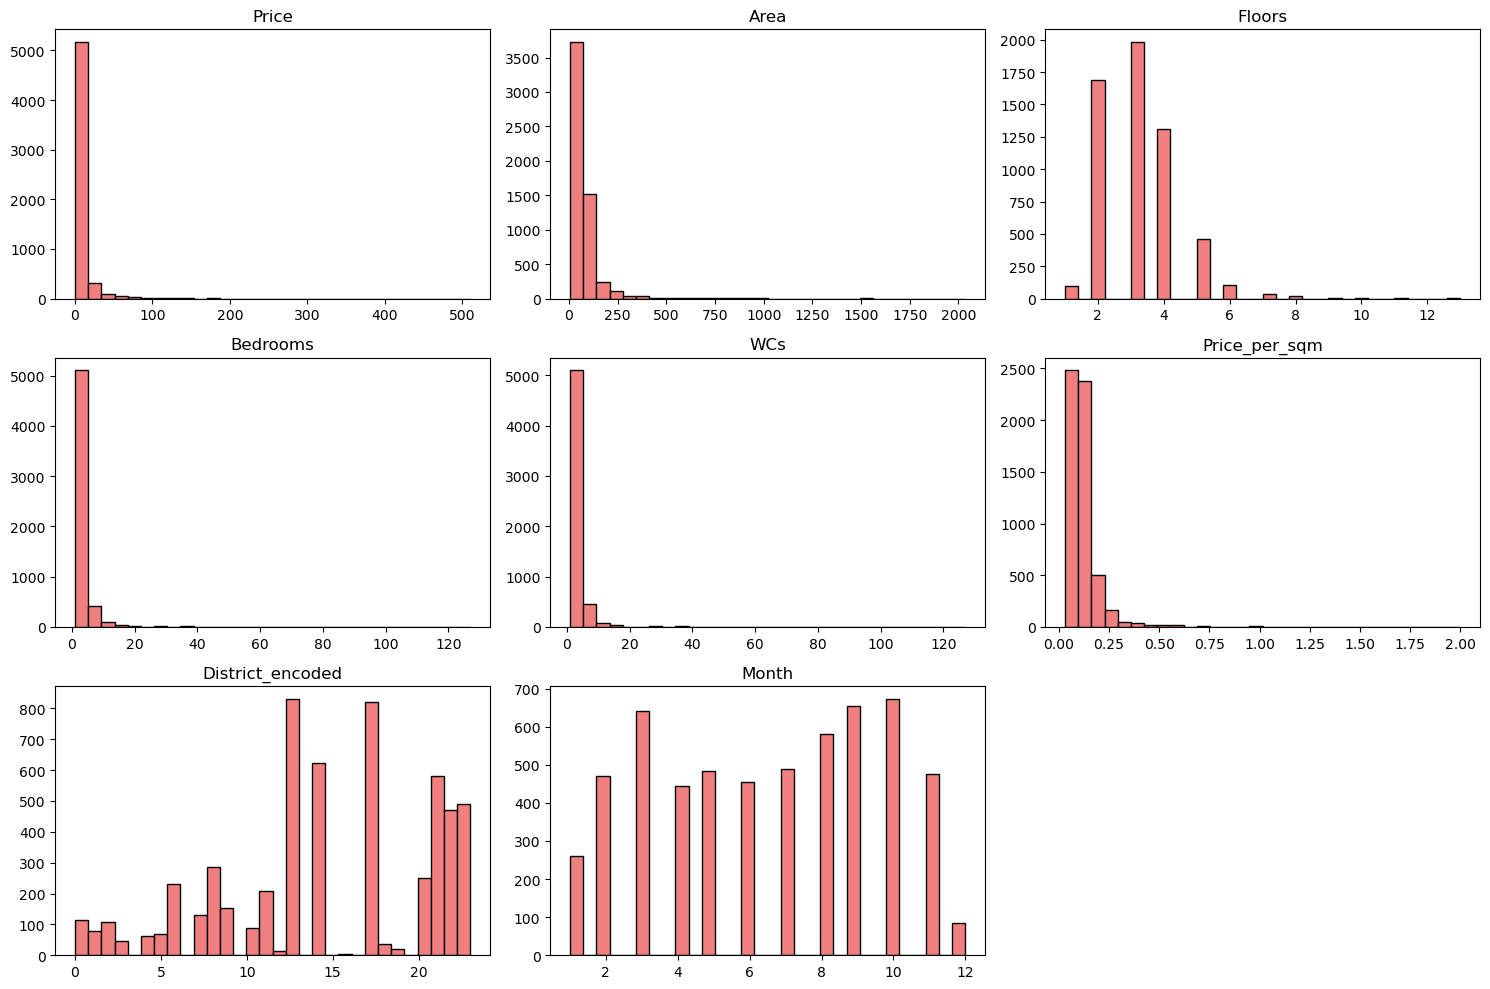

In [97]:
# Định nghĩa các biến số
numeric_features = ['Price', 'Area', 'Floors', 'Bedrooms', 'WCs', 'Price_per_sqm', 'District_encoded', 'Month']

# Vẽ Histogram cho các biến số
fig, axes = plt.subplots(len(numeric_features)//3 + 1, 3, figsize = (15, 10))

axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    ax.hist(df[feature], bins = 30, color = 'LightCoral', edgecolor = 'black')
    ax.set_title(feature)
    ax.grid(False)  # Xoá lưới

# Hide any unused subplots
for ax in axes[len(numeric_features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


**Insights:**

*   Right-skewed distributions: For **`Price`**, **`Area`**, **`Price_per_sqm`**, **`Bedrooms`**, and **`WCs`**, the right-skewed distributions indicate that most properties fall within a lower range for these attributes, with fewer properties having significantly higher values.

*   Outliers: There are noticeable outliers, especially in the **`Price`**, **`Area`**, **`Bedrooms`**, and **`WCs`** features, which could affect modeling and analysis.

*   Uniform distributions: The more uniform distribution of **`District_encoded`** and **`Month`** suggests a balanced representation of districts and months in dataset.

                     Price      Area    Floors  Bedrooms       WCs  \
Price             1.000000  0.658534  0.335754  0.370816  0.344697   
Area              0.658534  1.000000  0.245674  0.465207  0.466691   
Floors            0.335754  0.245674  1.000000  0.369551  0.384269   
Bedrooms          0.370816  0.465207  0.369551  1.000000  0.923106   
WCs               0.344697  0.466691  0.384269  0.923106  1.000000   
Price_per_sqm     0.497821  0.024879  0.238367  0.088418  0.089759   
District_encoded -0.136866 -0.023348 -0.091695 -0.039525 -0.035622   
Month             0.011585 -0.005062 -0.008320 -0.004057 -0.014946   

                  Price_per_sqm  District_encoded     Month  
Price                  0.497821         -0.136866  0.011585  
Area                   0.024879         -0.023348 -0.005062  
Floors                 0.238367         -0.091695 -0.008320  
Bedrooms               0.088418         -0.039525 -0.004057  
WCs                    0.089759         -0.035622 -0.014946

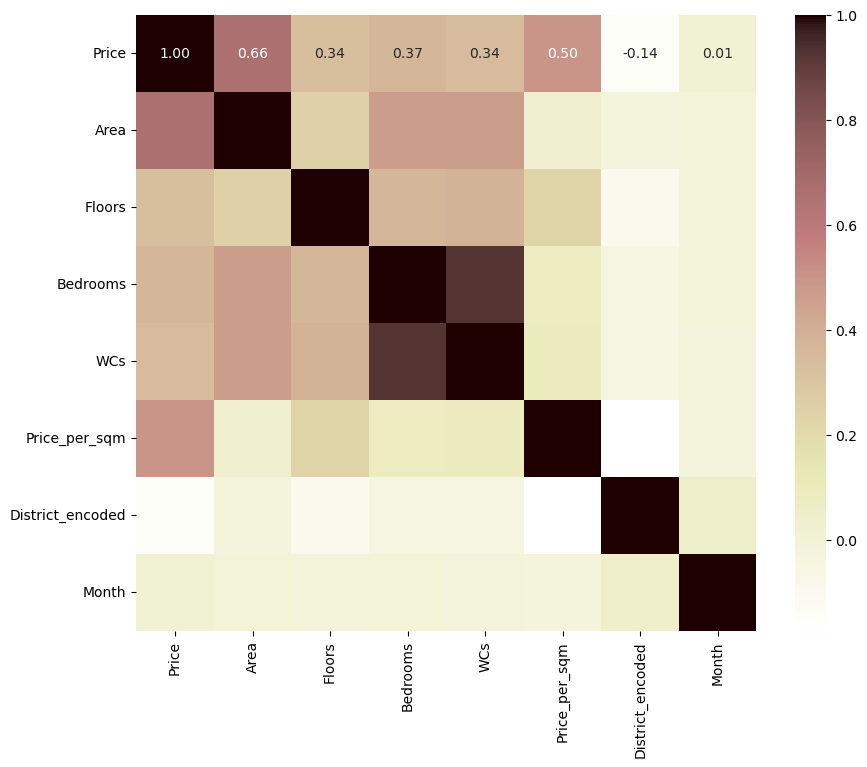

In [98]:
# Tính toán ma trận tương quan mà không bao gồm cột 'Price_per_sqm'
corr_matrix = df[numeric_features].corr()

# Hiển thị ma trận tương quan
print(corr_matrix)

# Vẽ Heatmap cho ma trận tương quan
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'pink_r', fmt = '.2f', cbar = True)
plt.show()

*   The area of the property is the most significant factor affecting the price, with a strong correlation of `0.68`.

*   The number of bedrooms and WCs also significantly impact the price, with correlations of `0.41` and `0.38`, respectively. Additionally, the number of floors shows a moderate impact with a correlation of `0.35`.

*   Frontage has a minimal effect on the price, with a weak correlation of `0.08`. The district has a slight negative correlation of `-0.13`, and the month shows almost no impact on the price, with a correlation of `0.02`.

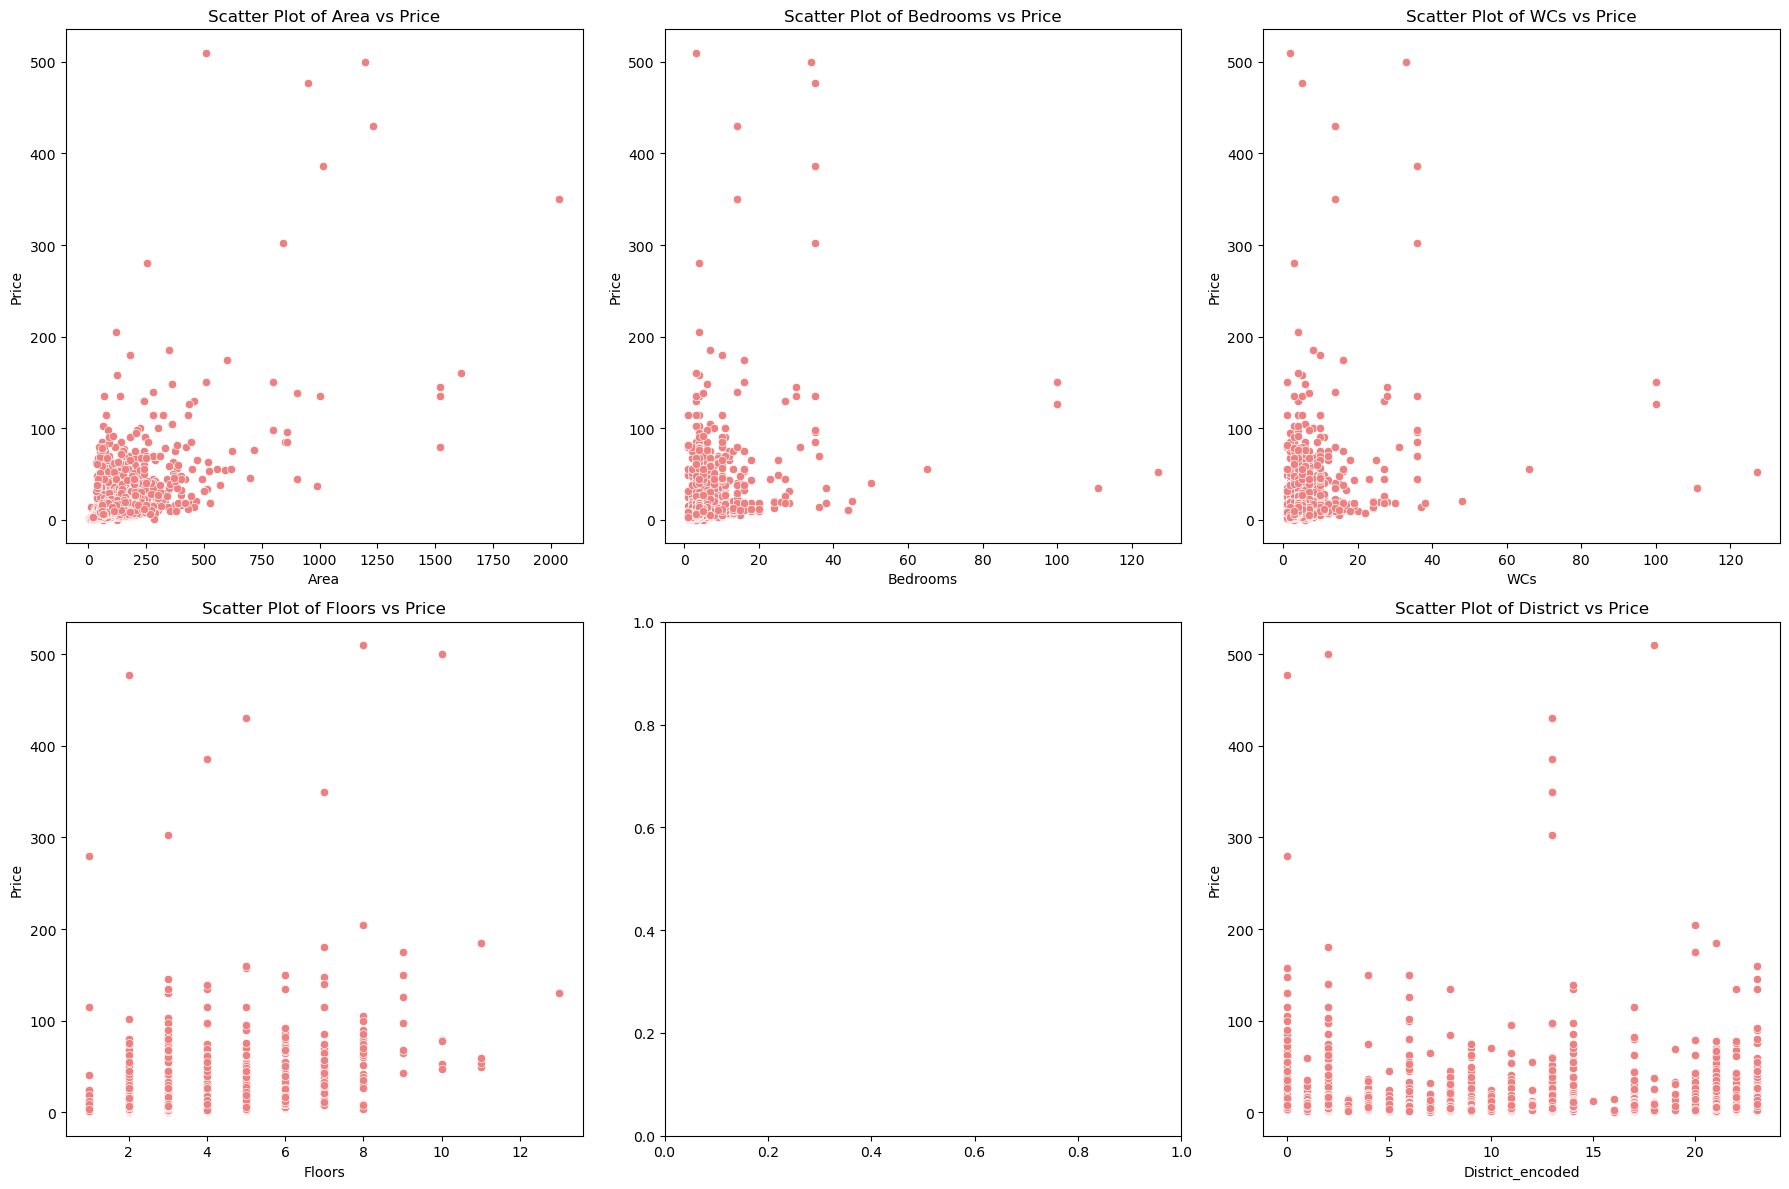

In [99]:
# Tạo một figure với sáu subplots trong hai hàng và ba cột
fig, axes = plt.subplots(2, 3, figsize = (18, 12))

# Scatter plot giữa Area và Price
sns.scatterplot(x = 'Area', y = 'Price', data = df, ax = axes[0, 0], color = 'lightcoral')
axes[0, 0].set_title('Scatter Plot of Area vs Price')

# Scatter plot giữa Bedrooms và Price
sns.scatterplot(x = 'Bedrooms', y = 'Price', data = df, ax = axes[0, 1], color = 'lightcoral')
axes[0, 1].set_title('Scatter Plot of Bedrooms vs Price')

# Scatter plot giữa WCs và Price
sns.scatterplot(x = 'WCs', y = 'Price', data = df, ax = axes[0, 2], color = 'lightcoral')
axes[0, 2].set_title('Scatter Plot of WCs vs Price')

# Scatter plot giữa Floors và Price
sns.scatterplot(x = 'Floors', y = 'Price', data = df, ax = axes[1, 0], color = 'lightcoral')
axes[1, 0].set_title('Scatter Plot of Floors vs Price')

# Scatter plot giữa District_encoded và Price
sns.scatterplot(x = 'District_encoded', y = 'Price', data = df, ax = axes[1, 2], color = 'lightcoral')
axes[1, 2].set_title('Scatter Plot of District vs Price')

# Điều chỉnh layout
plt.tight_layout()
plt.show()


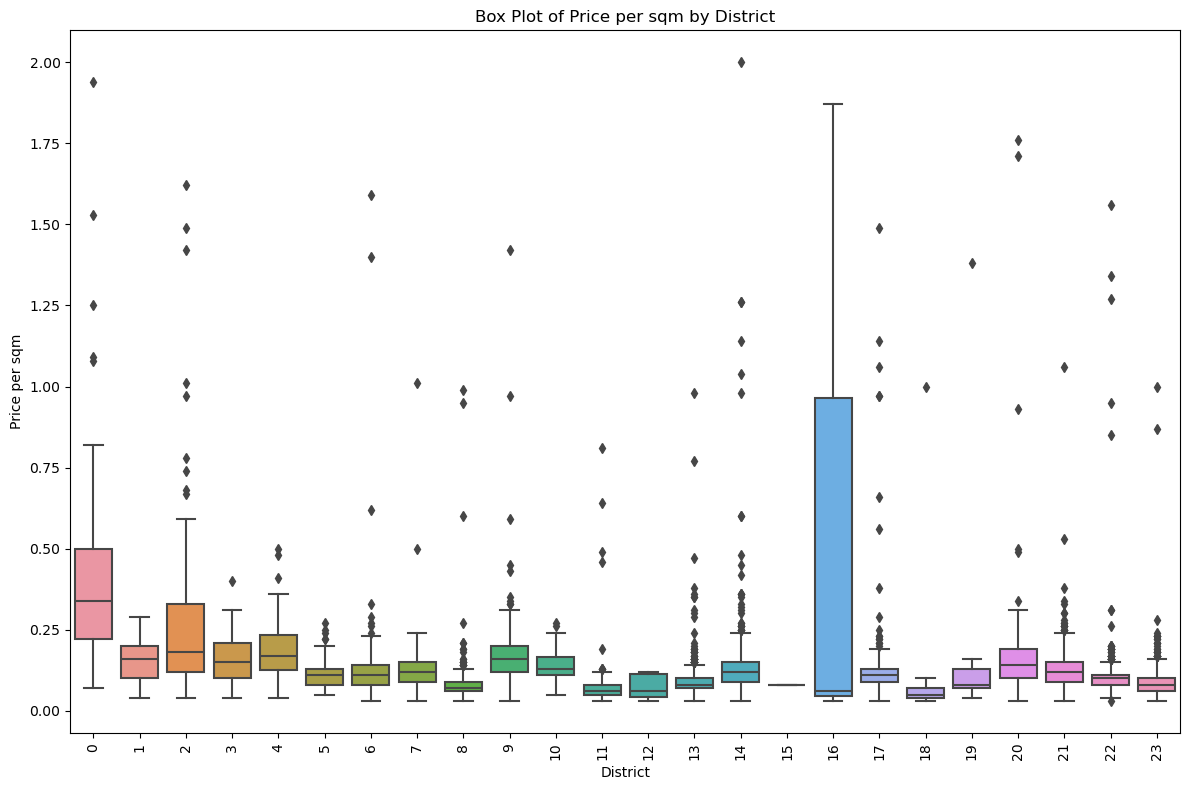

In [100]:

# Mã hóa cột 'District' nếu chưa có cột 'District_encoded'
if 'District_encoded' not in df.columns:
    df['District_encoded'] = pd.factorize(df['District'])[0]

# Tạo Box plot của Price_per_sqm theo District_encoded
plt.figure(figsize=(12, 8))
sns.boxplot(x='District_encoded', y='Price_per_sqm', data=df)
plt.title('Box Plot of Price per sqm by District')
plt.xlabel('District')
plt.ylabel('Price per sqm')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


*  **Price by District:**

     * Significant variation in house prices across districts.

     * Presence of high outliers in some districts.

*   **Price by Month:**

     * Fairly even distribution of prices across months.

     * Some months have high outliers.

*   **Price by Area Group:**

     * Prices tend to increase with larger area groups.

     * Higher area groups show more high outliers.

*  **Price by Bedrooms:**

     * More bedrooms generally correlate with higher prices, but with many outliers.

     * Higher bedroom counts (e.g., 9-10, 11+) show higher median prices.

*   **Price by WCs:**

     * More WCs tend to correlate with higher prices, but with many outliers.

     * Higher WC counts (e.g., 9-10, 11+) show higher median prices.

*   **Price by Floors:**

     * More floors tend to correlate with higher prices, but with many outliers.

     * Higher floors counts (e.g., 6+ ) show higher median prices.

In [101]:
# Hàm loại bỏ outliers (sử dụng lại hàm trước đó)
def remove_outliers_by_district(df, column='Price_per_sqm', group_column='District_encoded'):
    def remove_outliers(group):
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group_cleaned = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
        return group_cleaned

    df_cleaned = df.groupby(group_column).apply(remove_outliers).reset_index(drop=True)
    return df_cleaned

# Áp dụng hàm để loại bỏ outliers
df = remove_outliers_by_district(df)



In [102]:
def remove_invalid_1(df):
    return df[(df['Area'] > 10) & (df['Price'] > 1)]

# Áp dụng hàm để loại bỏ các hàng không hợp lệ
df = remove_invalid_1(df)



In [103]:
# Xuất dữ liệu đã xử lý ra file CSV mới
df.to_csv('../Data/clean_data.csv', index = False)

### **Visualize using heatmap and Kernel Density Estimation**

In [ ]:
# Đọc tệp shapefile sử dụng GeoPandas
gdf = gpd.read_file('../Data/gadm41_VNM_2.shp')

# Filter for TP.HCM
gdf_hcm = gdf[gdf['NAME_1'] == 'Há»\x93 ChÃ\xad Minh']

# Rename column "VARNAME2" to"District"
gdf_hcm = gdf_hcm.rename(columns = {'VARNAME_2': 'District'})

# Reformatting name of district
replace_dict = {'Binh Chanh':'binh-chanh', 'Binh Tan' : 'binh-tan','Binh Thanh':'binh-thanh', 'Can Gio':'can-gio',
 'Cu Chi':'cu-chi', 'Go Vap':'go-vap', 'Hoc Mon':'hoc-mon', 'Nha Be':'nha-be', 'Phu Nhuan':'phu-nhuan',
 'District 1':'quan-1', 'District 10':'quan-10', 'District 11':'quan-11', 'District 12':'quan-12', 'District 2':'quan-2',
 'District 3':'quan-3', 'District 4':'quan-4', 'District 5':'quan-5', 'District 6':'quan-6', 'District 7':'quan-7',
 'District 8':'quan-8', 'District 9':'quan-9', 'Tan Binh':'tan-binh',  'Tan Phu':'tan-phu', 'Thu Duc':'thu-duc'}
gdf_hcm['District'] = gdf_hcm['District'].replace(replace_dict)

# Read cleaned file with district
df = pd.read_csv('../Data/data_with_district.csv')

# Keep columns 'District','Price_per_sqm','Month' in dataframe
df = df[['District','Price_per_sqm','Month']]

# Merge geodataframe and dataframe to a new file csv contain data and geodata
df = gdf_hcm.merge(df, on = 'District')
df.to_csv('../Data/data_with_gadm.csv', index = False)

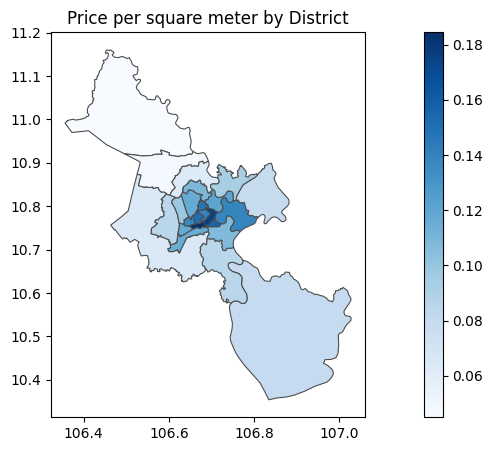

In [ ]:
# Nhóm dữ liệu theo cột 'District' và tính giá trị trung bình của 'Price_per_sqm' cho mỗi quận
price_per_sqm_mean_by_district = df.groupby('District')['Price_per_sqm'].mean().reset_index()

# Đổi tên cột để rõ ràng hơn
price_per_sqm_mean_by_district.rename(columns = {'Price_per_sqm': 'price_per_sqm_mean'}, inplace = True)

# Hợp nhất dữ liệu số lượng nhà bán với dữ liệu bản đồ hành chính
gdf = gdf_hcm.merge(price_per_sqm_mean_by_district, on = 'District')

# Vẽ bản đồ nhiệt
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

gdf.plot(column = 'price_per_sqm_mean', cmap = 'Blues', linewidth = 0.8, ax = ax, edgecolor = '0.3', legend = True)

plt.title('Price per square meter by District')
plt.show()

**Visualize a heatmap based on the price per square meter by District :**
* Các quận ở trung tâm có màu đậm hơn, biểu thị giá đất cao hơn so với các quận ở ngoại thành có màu nhạt hơn.

* Vùng trung tâm của bản đồ có giá đất cao nhất, được biểu thị bằng màu xanh đậm nhất, càng ra xa vùng trung tâm, màu xanh thể hiện giá đất càng nhạt


**Conclusion :**
* Giá đất biểu thị trong biểu đồ là hợp lý so với thực tế.

* Bộ dữ liệu sau khi xử lý có độ tin cậy cao, phù hợp để huấn luyện các mô hình máy học dự đoán giá nhà.

In [ ]:
data = pd.read_csv('../Data/data_with_gadm.csv')

# Chuyển đổi cột 'geometry' sang GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry = gpd.GeoSeries.from_wkt(data['geometry']))

# Trích xuất tọa độ trung tâm của mỗi quận
gdf['centroid'] = gdf.geometry.centroid.apply(lambda point: (point.x, point.y))

# Trích xuất tọa độ
coordinates = np.array(gdf['centroid'].tolist())

# Tạo KDE
kde = KernelDensity(bandwidth = 0.015, metric = 'euclidean')
kde.fit(coordinates)

KernelDensity(bandwidth=0.015)

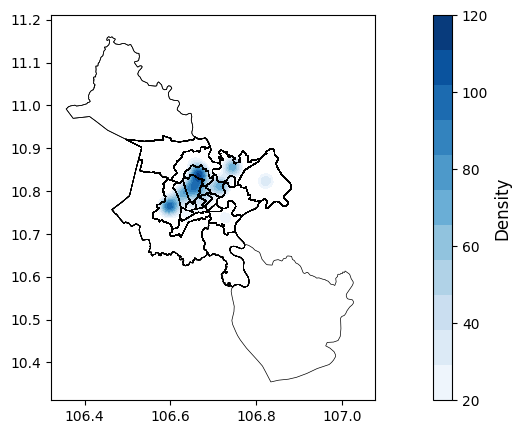

In [ ]:
# Đánh giá KDE trên một lưới điểm
xmin, ymin, xmax, ymax = gdf.total_bounds
xgrid = np.linspace(xmin + 0.05, xmax + 0.05, 100)
ygrid = np.linspace(ymin + 0.05, ymax + 0.05, 100)
X, Y = np.meshgrid(xgrid, ygrid)
xy_sample = np.vstack([X.ravel(), Y.ravel()]).T
Z = kde.score_samples(xy_sample)
Z = np.exp(Z).reshape(X.shape)

# Vẽ heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
contour = ax.contourf(X, Y, Z, levels=np.linspace(20, 120, 12), cmap='Blues')

# Thêm và tùy chỉnh color bar
cbar = plt.colorbar(contour, ax = ax)
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('Density', size = 12)
cbar.set_ticks(np.linspace(20, 120, 6))

# Vẽ bản đồ quận
gdf.boundary.plot(ax = plt.gca(), linewidth = 0.5, edgecolor = 'black')
plt.show()

**Visualize a heatmap based on the district of the listed house using kernel density estimation :**
* Các khu vực màu xanh đậm có mật độ nhà bán cao nhất, tập trung ở vùng gần khu vực trung tâm

* Các vùng màu xanh vừa đại diện cho các khu vực có mật độ nhà bán trung bình, bao quanh các khu vực có mật độ cao, cho thấy mật độ nhà bán giảm dần khi di chuyển ra khỏi trung tâm.

* Các vùng màu xanh nhạt và trắng biểu thị các khu vực có mật độ nhà bán thấp, nằm ở vùng ngoại vi của bản đồ, cho thấy các quận ngoại thành có ít nhà được liệt kê bán hơn

### **Methodology**

#### **Data Preparation**

In [ ]:
df = pd.read_csv('../Data/clean_data.csv')

In [ ]:
print(df)

      Price   Area  Bedrooms   WCs District  Floors  Legal_status  \
0      13.5   44.0       5.0   4.0   quan-1     5.0           0.0   
1       8.7   45.0       3.0   3.0   quan-1     4.0           1.0   
2      21.5   64.0       5.0   4.0   quan-1     4.0           1.0   
3       9.3   40.0       4.0   4.0   quan-1     4.0           1.0   
4     130.0  455.0      25.0  24.0   quan-1    13.0           0.0   
...     ...    ...       ...   ...      ...     ...           ...   
5445   26.8  200.0       5.0   5.0  thu-duc     3.0           1.0   
5446   13.5  104.7       4.0   4.0  thu-duc     4.0           1.0   
5447    6.8   68.0       4.0   3.0  thu-duc     3.0           1.0   
5448    6.5   62.5       3.0   2.0  thu-duc     2.0           0.0   
5449    9.5  113.0       5.0   3.0  thu-duc     4.0           1.0   

      Price_per_sqm  District_encoded  Month  Frontage_1  Frontage_0  
0              0.31                 0     11           1           0  
1              0.19          

In [ ]:
# Split the dataset into features (X) and the target variable (Y).
X = df.drop(columns = ['Price', 'Price_per_sqm', 'District', 'Month'])
y = df['Price']

numerical_features = ['Area', 'Bedrooms', 'WCs', 'Floors']

scaler = StandardScaler()

# Chuẩn hóa các đặc trưng số
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### **Regression models**

##### **Linear Regression**

In [ ]:
# Định nghĩa lớp LinearRegressionCustom

class LinearRegressionCustom:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        # Tính toán hệ số hồi quy bằng công thức hồi quy tuyến tính, sử dụng nghịch đảo giả
        XTX = X.T @ X
        if np.linalg.det(XTX) == 0:
            print("Matrix is singular, using pseudo-inverse")
            self.coef_ = np.linalg.pinv(XTX) @ X.T @ y
        else:
            self.coef_ = np.linalg.inv(XTX) @ X.T @ y

    def predict(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return X @ self.coef_

In [ ]:
linear_custom = LinearRegressionCustom(fit_intercept = True)
linear_custom.fit(X_train, y_train)

In [ ]:
y_test_pred_custom = linear_custom.predict(X_test)

In [ ]:
print("Custom Linear Regression - MSE:", mean_squared_error(y_test, y_test_pred_custom))
print("Custom Linear Regression - MAE:", mean_absolute_error(y_test, y_test_pred_custom))
print("Custom Linear Regression - R^2:", r2_score(y_test, y_test_pred_custom))

Custom Linear Regression - MSE: 46.77522102005464
Custom Linear Regression - MAE: 4.068477353981417
Custom Linear Regression - R^2: 0.5867772620727401


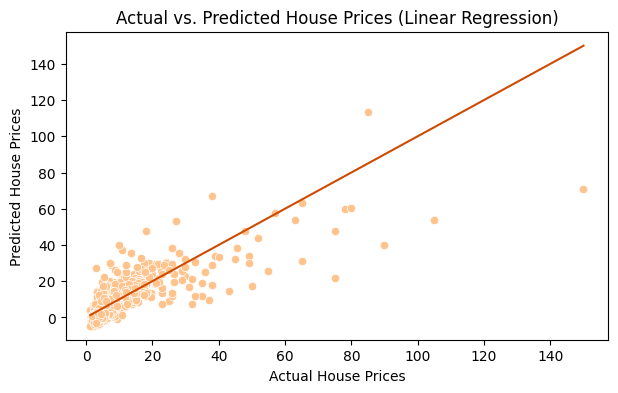

In [ ]:
# Tạo figure và các axes cho hai biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ toàn bộ dữ liệu
sns.scatterplot(x=y_test, y=y_test_pred_custom, color='#FFC48E', ax=ax1)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#CD4B02', linestyle='-')
ax1.set_title('Actual vs. Predicted House Prices (Linear Regression) - Full Range')
ax1.set_xlabel('Actual House Prices')
ax1.set_ylabel('Predicted House Prices')
ax1.grid(False)

# Biểu đồ giới hạn từ 0 tới 20
sns.scatterplot(x=y_test, y=y_test_pred_custom, color='#FFC48E', ax=ax2)
ax2.plot([0, 25], [0, 25], color='#CD4B02', linestyle='-')
ax2.set_title('Actual vs. Predicted House Prices (Linear Regression) - Limited to 0 - 25')
ax2.set_xlabel('Actual House Prices')
ax2.set_ylabel('Predicted House Prices')
ax2.set_xlim(0, 25)
ax2.set_ylim(0, 25)
ax2.grid(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


##### **Ridge Regression**

In [ ]:
# Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [ ]:
ridge_y_pred = ridge.predict(X_test)

print("Ridge Regression - MSE:", mean_squared_error(y_test, ridge_y_pred))
print("Ridge Regression - MAE:", mean_absolute_error(y_test, ridge_y_pred))
print("Ridge Regression - R^2:", r2_score(y_test, ridge_y_pred))

Ridge Regression - MSE: 46.75384511779384
Ridge Regression - MAE: 4.067478795929678
Ridge Regression - R^2: 0.586966101562223


In [ ]:
# Ridge Regression với GridSearchCV
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv = 5)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
ridge_y_pred_best = best_ridge.predict(X_test)

print("Best Ridge Regression - MSE:", mean_squared_error(y_test, ridge_y_pred_best))
print("Best Ridge Regression - MAE:", mean_absolute_error(y_test, ridge_y_pred_best))
print("Best Ridge Regression - R^2:", r2_score(y_test, ridge_y_pred_best))

Best Ridge Regression - MSE: 44.9393265136805
Best Ridge Regression - MAE: 3.980279858476248
Best Ridge Regression - R^2: 0.602995963725572


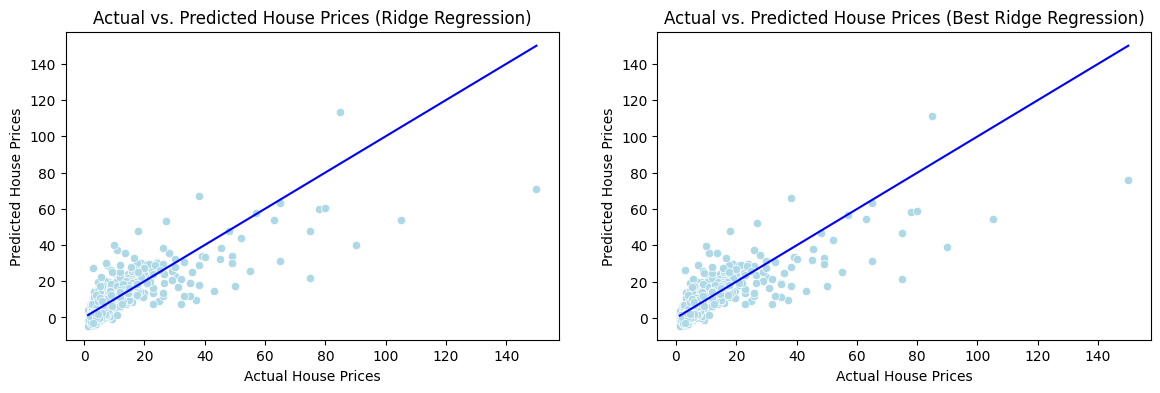

In [ ]:
# Create a scatter plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Ridge Regression full range
sns.scatterplot(x = y_test, y = ridge_y_pred, color = 'lightblue', ax=axes[0,0])
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'blue', linestyle = '-')
axes[0,0].set_title('Actual vs. Predicted House Prices (Ridge Regression) - Full Range')
axes[0,0].set_xlabel('Actual House Prices')
axes[0,0].set_ylabel('Predicted House Prices')
axes[0,0].grid(False)

# Plot for Ridge Regression limited 
sns.scatterplot(x = y_test, y = ridge_y_pred, color = 'lightblue', ax=axes[0,1])
axes[0,1].plot([0, 25], [0, 25], color = 'blue', linestyle = '-')
axes[0,1].set_title('Actual vs. Predicted House Prices (Ridge Regression) - Limited to 0 - 25')
axes[0,1].set_xlabel('Actual House Prices')
axes[0,1].set_ylabel('Predicted House Prices')
axes[0,1].set_xlim(0, 25)
axes[0,1].set_ylim(0, 25)
axes[0,1].grid(False)


# Plot for Best Ridge Regression full range
sns.scatterplot(x = y_test, y = ridge_y_pred_best, color = 'lightblue', ax=axes[1,0])
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'blue', linestyle = '-')
axes[1,0].set_title('Actual vs. Predicted House Prices (Best Ridge Regression) - Full Range')
axes[1,0].set_xlabel('Actual House Prices')
axes[1,0].set_ylabel('Predicted House Prices')
axes[1,0].grid(False)

# Plot for Best Ridge Regression limited
sns.scatterplot(x = y_test, y = ridge_y_pred_best, color = 'lightblue', ax=axes[1,1])
axes[1,1].plot([0, 25], [0, 25], color = 'blue', linestyle = '-')
axes[1,1].set_title('Actual vs. Predicted House Prices (Best Ridge Regression) - Limited to 0 - 25')
axes[1,1].set_xlabel('Actual House Prices')
axes[1,1].set_ylabel('Predicted House Prices')
axes[1,1].set_xlim(0, 25)
axes[1,1].set_ylim(0, 25)
axes[1,1].grid(False)


plt.grid(False)
plt.show()

##### **Lasso Regression**

In [ ]:
# Lasso Regression
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [ ]:
lasso_y_pred = lasso.predict(X_test)

print("Lasso Regression - MSE:", mean_squared_error(y_test, lasso_y_pred))
print("Lasso Regression - MAE:", mean_absolute_error(y_test, lasso_y_pred))
print("Lasso Regression - R^2:", r2_score(y_test, lasso_y_pred))

Lasso Regression - MSE: 41.01016312813962
Lasso Regression - MAE: 3.646916948654825
Lasso Regression - R^2: 0.6377070696600715


In [ ]:
# Lasso Regression với GridSearchCV
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv = 5)
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
lasso_y_pred_best = best_lasso.predict(X_test)

print("Best Lasso Regression - MSE:", mean_squared_error(y_test, lasso_y_pred_best))
print("Best Lasso Regression - MAE:", mean_absolute_error(y_test, lasso_y_pred_best))
print("Best Lasso Regression - R^2:", r2_score(y_test, lasso_y_pred_best))


Best Lasso Regression - MSE: 41.01016312813962
Best Lasso Regression - MAE: 3.646916948654825
Best Lasso Regression - R^2: 0.6377070696600715


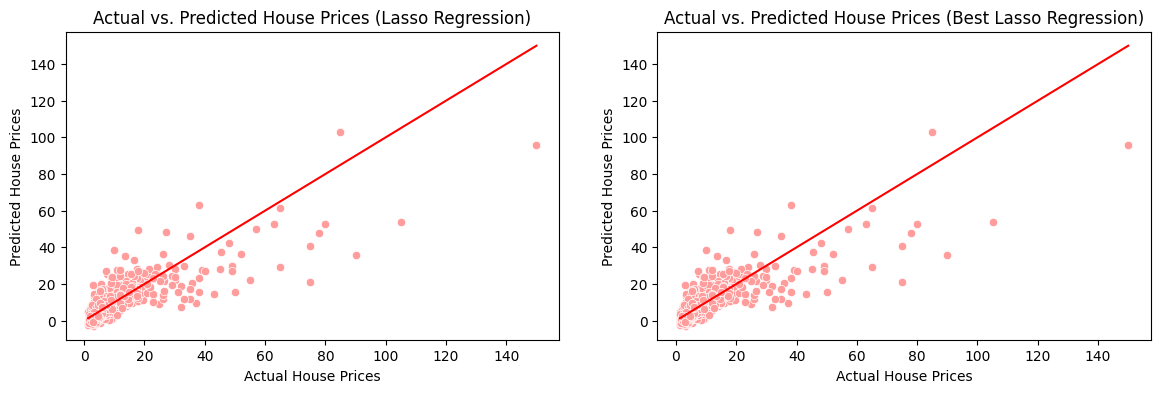

In [ ]:
# # Create a scatter plot
# fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# # Plot for Lasso Regression
# sns.scatterplot(x = y_test, y = lasso_y_pred, color = 'pink', ax=axes[0])
# axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'deeppink', linestyle = '-')
# axes[0].set_title('Actual vs. Predicted House Prices (Lasso Regression)')
# axes[0].set_xlabel('Actual House Prices')
# axes[0].set_ylabel('Predicted House Prices')

# # Plot for Best Lasso Regression
# sns.scatterplot(x = y_test, y = lasso_y_pred_best, color = 'pink', ax=axes[1])
# axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'deeppink', linestyle = '-')
# axes[1].set_title('Actual vs. Predicted House Prices (Best Lasso Regression)')
# axes[1].set_xlabel('Actual House Prices')
# axes[1].set_ylabel('Predicted House Prices')


# plt.grid(False)
# plt.show()

# Create a scatter plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Lasso Regression full range
sns.scatterplot(x = y_test, y = lasso_y_pred, color = '#FF9C9C', ax=axes[0,0])
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red', linestyle = '-')
axes[0,0].set_title('Actual vs. Predicted House Prices (Lasso Regression) - Full Range')
axes[0,0].set_xlabel('Actual House Prices')
axes[0,0].set_ylabel('Predicted House Prices')
axes[0,0].grid(False)

# Plot for Lasso Regression limited 
sns.scatterplot(x = y_test, y = lasso_y_pred, color = '#FF9C9C', ax=axes[0,1])
axes[0,1].plot([0, 25], [0, 25], color = 'red', linestyle = '-')
axes[0,1].set_title('Actual vs. Predicted House Prices (Lasso Regression) - Limited to 0 - 25')
axes[0,1].set_xlabel('Actual House Prices')
axes[0,1].set_ylabel('Predicted House Prices')
axes[0,1].set_xlim(0, 25)
axes[0,1].set_ylim(0, 25)
axes[0,1].grid(False)


# Plot for Best Lasso Regression full range
sns.scatterplot(x = y_test, y = lasso_y_pred_best, color = '#FF9C9C', ax=axes[1,0])
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red', linestyle = '-')
axes[1,0].set_title('Actual vs. Predicted House Prices (Best Lasso Regression) - Full Range')
axes[1,0].set_xlabel('Actual House Prices')
axes[1,0].set_ylabel('Predicted House Prices')
axes[1,0].grid(False)

# Plot for Best Lasso Regression limited
sns.scatterplot(x = y_test, y = lasso_y_pred_best, color = '#FF9C9C', ax=axes[1,1])
axes[1,1].plot([0, 25], [0, 25], color = 'red', linestyle = '-')
axes[1,1].set_title('Actual vs. Predicted House Prices (Best Lasso Regression) - Limited to 0 - 25')
axes[1,1].set_xlabel('Actual House Prices')
axes[1,1].set_ylabel('Predicted House Prices')
axes[1,1].set_xlim(0, 25)
axes[1,1].set_ylim(0, 25)
axes[1,1].grid(False)


plt.grid(False)
plt.show()

##### **Compare 3 Regression models**

In [ ]:
# Tạo bảng so sánh
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'MAE': [mean_absolute_error(y_test, y_test_pred_custom), mean_absolute_error(y_test, ridge_y_pred_best), mean_absolute_error(y_test, lasso_y_pred_best)],
    'MSE': [mean_squared_error(y_test, y_test_pred_custom), mean_squared_error(y_test, ridge_y_pred_best), mean_squared_error(y_test, lasso_y_pred_best)],
    'R^2': [r2_score(y_test, y_test_pred_custom), r2_score(y_test, ridge_y_pred_best), r2_score(y_test, lasso_y_pred_best)]
})

print(results)

               Model       MAE        MSE       R^2
0  Linear Regression  4.068477  46.775221  0.586777
1   Ridge Regression  3.980280  44.939327  0.602996
2   Lasso Regression  3.646917  41.010163  0.637707


**Conclusion**

Vì Linear Regression có các metrics tốt nhất trong 3 mô hình regression nên chọn Linear Regression làm baseline model cho đồ án này.

#### **Decision Tree and Random Forest**

In [ ]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, value = None):
        self.feature = feature      # chỉ số của đặc trưng để chia
        self.threshold = threshold  # ngưỡng để chia đặc trưng
        self.left = left            # cây con bên trái (nhỏ hơn hoặc bằng ngưỡng)
        self.right = right          # cây con bên phải (lớn hơn ngưỡng)
        self.value = value          # giá trị của nút lá (trung bình giá trị y)

In [ ]:
class DecisionTreeRegressor:
    def __init__(self, max_depth = None, random_state = None):
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree_ = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs, self.tree_) for inputs in X])

    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or len(set(y)) == 1:
            return Node(value=np.mean(y))

        feature_indices = np.random.choice(n_features, n_features, replace = False)
        best_feature, best_threshold = self._best_criteria(X, y, feature_indices)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

        if not np.any(left_indices) or not np.any(right_indices):
            return Node(value = np.mean(y))

        left_tree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(best_feature, best_threshold, left_tree, right_tree)

    def _best_criteria(self, X, y, feature_indices):
        best_gain = -1
        split_idx, split_threshold = None, None
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature_idx], threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold
        return split_idx, split_threshold

    def _information_gain(self, y, feature_values, threshold):
        parent_loss = self._mse(y)
        left_indices = feature_values <= threshold
        right_indices = ~left_indices
        if not np.any(left_indices) or not np.any(right_indices):
            return 0
        left_loss = self._mse(y[left_indices])
        right_loss = self._mse(y[right_indices])
        n = len(y)
        n_left = len(y[left_indices])
        n_right = len(y[right_indices])
        child_loss = (n_left / n) * left_loss + (n_right / n) * right_loss
        return parent_loss - child_loss

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _predict(self, inputs, node):
        while node.left:
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


In [ ]:
class RandomForestRegressor:
    def __init__(self, n_estimators = 100, max_depth = None, max_features = 'sqrt', random_state = None, n_jobs = -1):
        """
        Khởi tạo mô hình RandomForestRegressor.

        Tham số:
        - n_estimators (int): Số lượng cây quyết định trong rừng.
        - max_depth (int): Độ sâu tối đa của mỗi cây quyết định. Nếu None, các cây sẽ được phát triển đầy đủ.
        - max_features (str): Số lượng đặc trưng tối đa được xem xét để phân chia tại mỗi nút.
        - random_state (int): Seed để đảm bảo tính nhất quán của random state.
        - n_jobs (int): Số lượng công việc song song hóa.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.estimators = []

    def _bootstrap_sample(self, X, y):
        """
        Tạo một mẫu bootstrap từ dữ liệu gốc.

        Tham số:
        - X (numpy array, shape = [n_samples, n_features]): Dữ liệu đầu vào.
        - y (numpy array, shape = [n_samples]): Nhãn của dữ liệu huấn luyện.

        Returns:
        - X_sample (numpy array, shape = [n_samples, n_features]): Mẫu bootstrap của dữ liệu đầu vào.
        - y_sample (numpy array, shape = [n_samples]): Nhãn của mẫu bootstrap.
        """
        n_samples = len(X)
        indices = np.random.choice(n_samples, size=n_samples, replace = True)
        return X[indices], y[indices]

    def fit(self, X, y):
        """
        Huấn luyện mô hình RandomForest dựa trên dữ liệu huấn luyện.

        Tham số:
        - X (numpy array, shape = [n_samples, n_features]): Dữ liệu đầu vào.
        - y (numpy array, shape = [n_samples]): Nhãn của dữ liệu huấn luyện.
        """
        np.random.seed(self.random_state)
        def _fit_single_tree(random_state):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = DecisionTreeRegressor(max_depth = self.max_depth, random_state = random_state)
            tree.fit(X_sample, y_sample)
            return tree

        random_states = np.random.randint(0, 10000, size = self.n_estimators)
        self.estimators = Parallel(n_jobs = self.n_jobs)(delayed(_fit_single_tree)(rs) for rs in random_states)

    def predict(self, X):
        """
        Dự đoán giá trị cho dữ liệu đầu vào mới.

        Tham số:
        - X (numpy array, shape = [n_samples, n_features]): Dữ liệu đầu vào cần dự đoán.

        Returns:
        - predictions (numpy array, shape = [n_samples]): Giá trị dự đoán tương ứng với mỗi mẫu đầu vào.
        """
        all_predictions = np.zeros((len(X), self.n_estimators))
        for i, tree in enumerate(self.estimators):
            all_predictions[:, i] = tree.predict(X)
        return np.mean(all_predictions, axis = 1)

In [ ]:
"""
    Tìm kiếm trên lưới để tối ưu hóa độ sâu  trong mô hình hồi quy.

    Tham số:
    - X_train (numpy array): Dữ liệu huấn luyện (features).
    - y_train (numpy array): Nhãn của dữ liệu huấn luyện.
    - X_test (numpy array): Dữ liệu kiểm tra (features).
    - y_test (numpy array): Nhãn của dữ liệu kiểm tra.
    - max_depths (list): Danh sách các giá trị độ sâu để thử nghiệm.

    Returns:
    - best_depth (int): Độ sâu tối ưu.
    - best_mse (float): Giá trị MSE tối ưu tương ứng với độ sâu tối ưu.
"""

def simple_grid_search_decision_tree(X_train, y_train, X_test, y_test, max_depths):

    best_depth = None
    best_mse = float('inf')

    for depth in max_depths:
        model = DecisionTreeRegressor(max_depth = depth, random_state = 42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_depth = depth

    return best_depth, best_mse


def simple_grid_search_random_forest(X_train, y_train, X_test, y_test, max_depths):

    best_depth = None
    best_mse = float('inf')

    for depth in max_depths:
        model = RandomForestRegressor(max_depth = depth, random_state = 42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < best_mse:
            best_mse = mse
            best_depth = depth

    return best_depth, best_mse

In [ ]:
# Tìm giá trị max_depth tốt nhất
max_depths = [None, 10, 20, 30, 40, 50]
best_depth_dt, best_mse_dt = simple_grid_search_decision_tree(X_train.values, y_train.values, X_test.values, y_test.values, max_depths)
print(f"Best max_depth for DecisionTree: {best_depth_dt}, Best MSE: {best_mse_dt}")

Best max_depth for DecisionTree: 10, Best MSE: 39.18554332443754


In [ ]:
best_depth_rf, best_mse_rf = simple_grid_search_random_forest(X_train.values, y_train.values, X_test.values, y_test.values, max_depths)
print(f"Best max_depth for RandomForest: {best_depth_rf}, Best MSE: {best_mse_rf}")

Best max_depth for RandomForest: 50, Best MSE: 21.957794995268156


In [ ]:
# Sử dụng DecisionTree bạn đã định nghĩa để huấn luyện mô hình
tree = DecisionTreeRegressor(max_depth = 10, random_state = 42)
tree.fit(X_train.values, y_train.values)

# Dự đoán trên tập kiểm tra
Y_pred_tree = tree.predict(X_test.values)

# Đánh giá hiệu suất của mô hình

print("Decision Tree Regression - MSE:", mean_squared_error(y_test.values, Y_pred_tree))
print("Decision Tree Regression - MAE:", mean_absolute_error(y_test.values, Y_pred_tree))
print("Decision Tree Regression - R^2:", r2_score(y_test.values, Y_pred_tree))

Decision Tree Regression - MSE: 39.18554332443754
Decision Tree Regression - MAE: 2.653982200623132
Decision Tree Regression - R^2: 0.6538261680741402


In [ ]:
# Huấn luyện mô hình Random Forest
random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 50, random_state = 42)
random_forest.fit(X_train.values, y_train.values)  # Huấn luyện trên tập huấn luyện

# Dự đoán giá nhà trên tập kiểm tra
Y_pred_forest = random_forest.predict(X_test.values)

# Đánh giá hiệu suất của mô hình

print("Random Forest Regression - MSE:", mean_squared_error(y_test.values, Y_pred_forest))
print("Random Forest Regression - MAE:", mean_absolute_error(y_test.values, Y_pred_forest))
print("Random Forest Regression - R^2:", r2_score(y_test.values, Y_pred_forest))

Random Forest Regression - MSE: 22.75329460705416
Random Forest Regression - MAE: 2.2329186260324048
Random Forest Regression - R^2: 0.7989923192375438


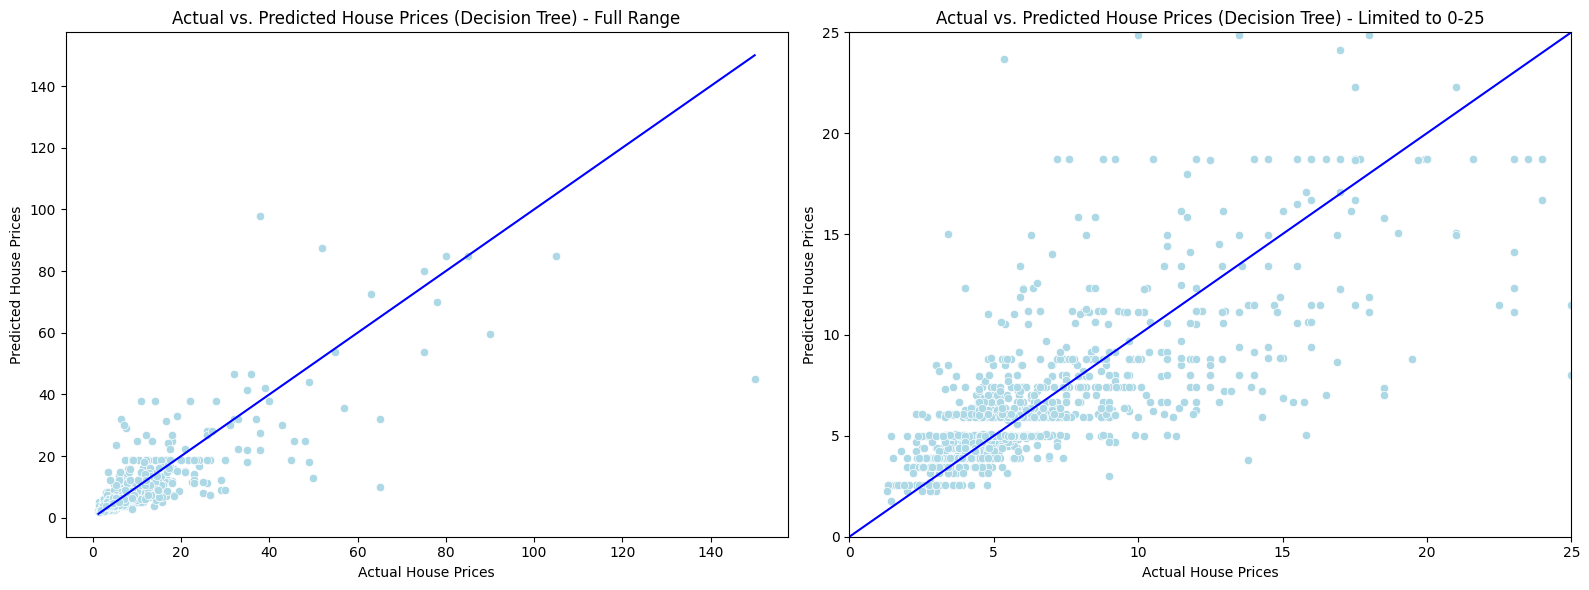

In [ ]:
# Tạo figure và các axes cho hai biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ toàn bộ dữ liệu
sns.scatterplot(x = y_test, y = Y_pred_tree, color = 'lightblue', ax = ax1)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='-')
ax1.set_title('Actual vs. Predicted House Prices (Decision Tree) - Full Range')
ax1.set_xlabel('Actual House Prices')
ax1.set_ylabel('Predicted House Prices')
ax1.grid(False)

# Biểu đồ giới hạn từ 0 tới 20
sns.scatterplot(x=y_test, y=Y_pred_tree, color='lightblue', ax=ax2)
ax2.plot([0, 25], [0, 25], color='blue', linestyle='-')
ax2.set_title('Actual vs. Predicted House Prices (Decision Tree) - Limited to 0-25')
ax2.set_xlabel('Actual House Prices')
ax2.set_ylabel('Predicted House Prices')
ax2.set_xlim(0, 25)
ax2.set_ylim(0, 25)
ax2.grid(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


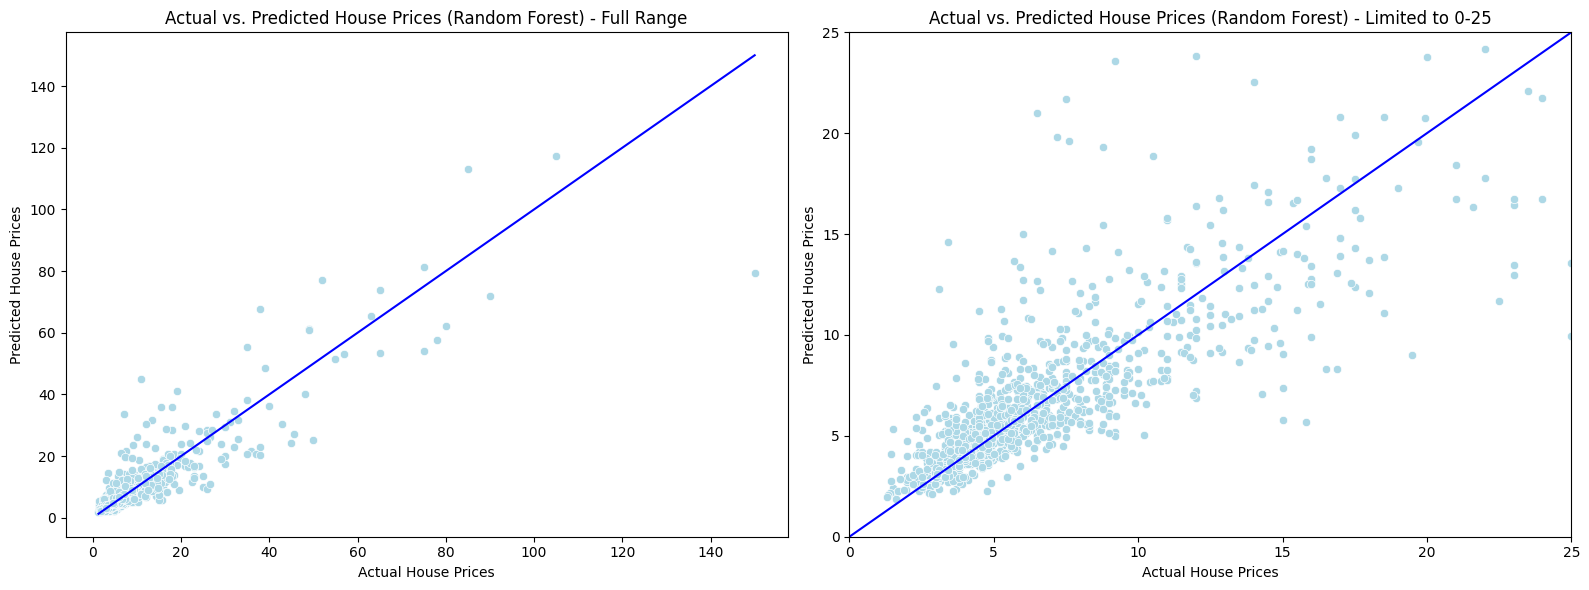

In [ ]:
# Tạo figure và các axes cho hai biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ toàn bộ dữ liệu
sns.scatterplot(x=y_test, y=Y_pred_forest, color='lightblue', ax=ax1)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue', linestyle='-')
ax1.set_title('Actual vs. Predicted House Prices (Random Forest) - Full Range')
ax1.set_xlabel('Actual House Prices')
ax1.set_ylabel('Predicted House Prices')
ax1.grid(False)

# Biểu đồ giới hạn từ 0 tới 20
sns.scatterplot(x=y_test, y=Y_pred_forest, color='lightblue', ax=ax2)
ax2.plot([0, 25], [0, 25], color='blue', linestyle='-')
ax2.set_title('Actual vs. Predicted House Prices (Random Forest) - Limited to 0-25')
ax2.set_xlabel('Actual House Prices')
ax2.set_ylabel('Predicted House Prices')
ax2.set_xlim(0, 25)
ax2.set_ylim(0, 25)
ax2.grid(False)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


#### **Gradient Boosting**

In [ ]:
# Tìm các tham số tối ưu cho mô hình Gradient Boosting (sử dụng RandomSearchCV)
# Khởi tạo mô hình
model = GradientBoostingRegressor(random_state = 42)

# Định nghĩa các tham số cần điều chỉnh
"""
n_estimators: số lượng cây trong ensemble.
max_depth: độ sâu tối đa của mỗi cây quyết định.
min_samples_split: số lượng mẫu tối thiểu cần thiết để chia một nút nội bộ.
min_samples_leaf: số lượng mẫu tối thiểu cần thiết để thành một lá trong cây.
subsample: tỷ lệ mẫu được sử dụng để huấn luyện mỗi cây.
learning_rate: tỷ lệ học, dùng để điều chỉnh đóng góp của mỗi cây.
"""
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Khởi tạo RandomizedSearchCV
"""
estimator: mô hình máy học cần được tối ưu hóa
param_distributions: danh sách các tham số của mô hình cần tối ưu hóa cùng với các giá trị mà chúng có thể nhận
n_iter: số lượng lần lặp để tìm kiếm ngẫu nhiên trong không gian tham số
cv: số lượng fold trong cross-validation để đánh giá mô hình
n_jobs: số lượng công việc được chạy đồng thời (-1 nghĩa là sử dụng tất cả các CPU)
scoring: điểm số (metrics) mà chúng ta sử dụng để đánh giá hiệu suất của mô hình
verbose: cấp độ thông tin chi tiết của quá trình huấn luyện
random_state: giá trị đảm bảo tính nhất quán trong việc chọn tổ hợp tham số ngẫu nhiên
"""
random_search = RandomizedSearchCV(estimator = model, param_distributions = param_distributions,
                                   n_iter = 100, cv = 5, n_jobs = -1, scoring = 'r2', verbose = 2, random_state = 42)

# Huấn luyện RandomizedSearchCV
random_search.fit(X_train, y_train)

# Find the best parameters
print(f"Best parameters: {random_search.best_params_}")
print(f"Best R^2 Score: {random_search.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.05}
Best R^2 Score: 0.7005672521986757


In [ ]:
# Chọn ra mô hình với tham số tối ưu nhất
best_model = random_search.best_estimator_

In [ ]:
# Đánh giá mô hình GradientBoosting đã chọn

predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 25.664904840923825
Mean Absolute Error (MAE): 2.2626038916522853
R^2 Score: 0.7732705048584987


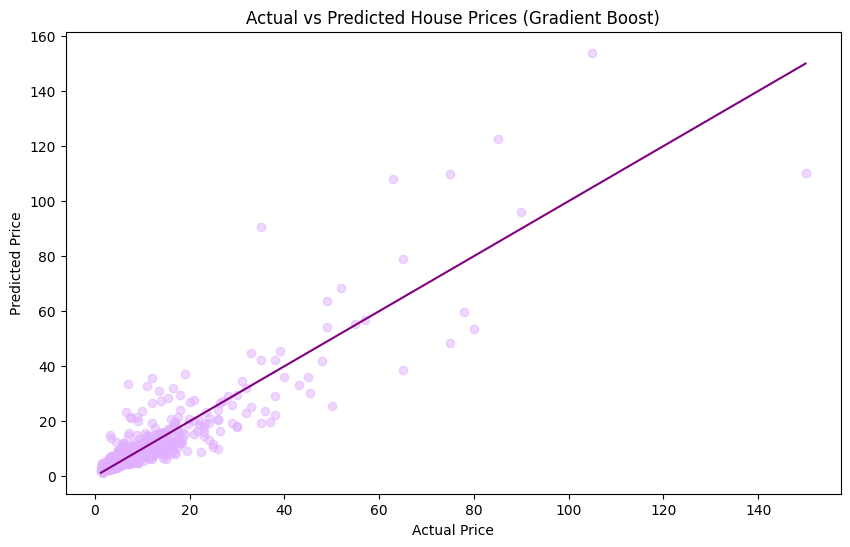

In [ ]:
# Visualize the plot comparing predicted results with actual data on testing dataset
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Gradient Boosting full range
sns.scatterplot(x = y_test.values, y = predictions, color = '#E0B0FF', ax=axes[0])
axes[0].plot([y_test.values.min(), y_test.values.max()], [y_test.values.min(), y_test.values.max()], color = 'purple', linestyle = '-')
axes[0].set_title('Actual vs. Predicted House Prices (Gradient Boosting) - Full Range')
axes[0].set_xlabel('Actual House Prices')
axes[0].set_ylabel('Predicted House Prices')
axes[0].grid(False)

# Plot for Gradient Boosting limited 
sns.scatterplot(x = y_test.values, y = predictions, color = '#E0B0FF', ax=axes[1])
axes[1].plot([0, 25], [0, 25], color = 'purple', linestyle = '-')
axes[1].set_title('Actual vs. Predicted House Prices (Gradient Boosting) - Limited to 0 - 25')
axes[1].set_xlabel('Actual House Prices')
axes[1].set_ylabel('Predicted House Prices')
axes[1].set_xlim(0, 25)
axes[1].set_ylim(0, 25)
axes[1].grid(False)


plt.grid(False)
plt.show()

#### **Deep Learning**

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

c:\Users\Phuong\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose=1)

Epoch 1/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 234.8790 - val_loss: 119.2855
Epoch 2/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138.4446 - val_loss: 73.7695
Epoch 3/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.9720 - val_loss: 52.2487
Epoch 4/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 225.6727 - val_loss: 43.7122
Epoch 5/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.1238 - val_loss: 47.3817
Epoch 6/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73.6641 - val_loss: 44.1150
Epoch 7/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74.1769 - val_loss: 46.4148
Epoch 8/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.5664 - val_loss: 56.0565
Epoch 9/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.4251 - val_loss: 53.2210
Epoch 10/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 189.9191 - val_loss: 51.6585
Epoch 11/200
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.8866 - val_loss: 61.9939
Epoch 12/200


In [ ]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')
print(f'RMSE: {rmse}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 31.962541965643965
MAE: 2.7019653610658207
R^2: 0.7176357735114575
RMSE: 5.653542426270803


## **DISCUSSION**

### **Overview**

| **Linear Regression** | **Decision Tree** | **Random Forest** | **Gradient Boosting** | **Deep Learning** |
|-|-|-|-|-|
|Là phương pháp thống kê dùng để mô hình hóa mối quan hệ giữa một biến phụ thuộc và nhiều biến độc lập, bằng cách tìm ra một đường thẳng hoặc mặt phẳng sao cho tổng bình phương các sai số giữa giá trị thực tế và giá trị dự đoán là nhỏ nhất.| ... | ... | GBR là một thuật toán học máy thuộc loại ensemble learning, tức là nó kết hợp nhiều mô hình yếu để tạo ra một mô hình mạnh mẽ hơn. Ở đây, mô hình yếu được lựa chọn là Decision Tree | ... |

### **Reasons for choosing the model**

| **Linear Regression** | **Decision Tree** | **Random Forest** | **Gradient Boosting** | **Deep Learning** |
|-|-|-|-|-|
| Tính đơn giản, dễ hiểu với thời gian tính toán nhanh chóng | ... | ... | GBR có thể xử lý các mô hình phi tuyến và phức tạp, giúp mô hình học được các quan hệ phức tạp giữa các biến đầu ra và đầu vào | ... |

### **How the model works**

| **Linear Regression** | **Decision Tree** | **Random Forest** | **Gradient Boosting** | **Deep Learning** |
|-|-|-|-|-|
| Sử dụng phương pháp Ordinary Least Squares (OLS), cố gắng giảm thiểu tổng bình phương sai số (Residual Sum of Squares - RSS), để ước lượng các hệ số hồi quy rồi dự đoán giá trị của biến phụ thuộc. | ... | ... | Mỗi Decision Tree xây dựng theo cách tuần tự (sequential). Đầu tiên, một cây đơn giản được huấn luyện giữa trên dữ liệu ban đầu để dự đoán giá trị mục tiêu. Sau đó, các cây tiếp thoe được xây dựng để sửa đổi và cải thiện lỗi của cây trước đó. Quá trình này làm tăng dần độ chính xác của mô hình bằng cách tập trung vào việc khắc phục những sai số còn lại. Ở đây, thuật toán sử dụng phương pháp Gradient Descent để tối thiểu Loss Function, giúp điều chỉnh các dự đoán của mỗi cây quyết định để làm giảm sai số. Mỗi cây quyết định mới được huấn luyện để tối ưu hóa hàm mất mát tích lũy (cumulative loss), tức là hàm mất mát trên toàn bộ chuỗi các cây đã xây dựng. | ... |

### **Pros and Cons**

| | **Linear Regression** | **Decision Tree** | **Random Forest** | **Gradient Boosting** | **Deep Learning** |
|-|-|-|-|-|-|
| **Advantage** | Dễ hiểu, dễ triển khai, dễ giải thích; Tính toán nhanh chóng, hiệu quả trên các tập dữ liệu nhỏ; Không yêu cầu nhiều tài nguyên tính toán | ... | ... | Hiệu suất cao; Khả năng xử lý các đặc trưng phức tạp, và không tuyến tính; Khả năng tùy chỉnh nhiều siêu tham số để mô hình đạt hiệu suất tốt nhất với từng bài toán cụ thể; Khả năng chống Overfitting tốt hơn cây đơn lẻ. | ... |
| **Disadvantage** | Giả định về mối quan hệ không luôn đúng trong thực tế; Nhạy cảm với outliers; Không phù hợp với dữ liệu phi tuyến | ... | ... | Thời gian huấn luyện dài; Yêu cầu tài nguyên tính toán cao; Nhạy cảm với siêu tham số | ... |

### **Compare with Baseline model (Linear Regression)**

| | **Decision Tree** | **Random Forest** | **Gradient Boosting** | **Deep Learning** |
|-|-|-|-|-|
| **Advantage** | ... | ... | GB có hiệu suất cao hơn với dữ liệu phi tuyến, có thể xử lý các đặc trưng phức tạp và ít bị ảnh hưởng bởi các outlier. | ... |
| **Disadvantage** | ... | ... | GB lại phức tạp và khó giải thích về mối quan hệ giữa các biến hơn so với LG, cùng với thời gian huấn luyện lâu hơn và yêu cầu tài nguyên cao hơn. Bên cạnh đó, mô hình dễ nhạy cảm với các siêu tham số  vì có nhiều tham số cần được điều chỉnh và tối ưu hơn. | ... |

**1. Tổng quan về Decision Tree**

* Decision Tree (Cây quyết định) là một mô hình học máy phân loại và hồi quy. Mô hình này sử dụng cấu trúc cây, trong đó mỗi nút bên trong đại diện cho một thuộc tính (đặc trưng) và mỗi nhánh đại diện cho một giá trị của thuộc tính đó. Các nút lá thể hiện các giá trị mục tiêu (kết quả). Mô hình cây quyết định có thể được sử dụng cho cả bài toán phân loại và hồi quy.


**2. Lí do chọn mô hình hồi quy**

* Bản chất của biến mục tiêu: Giá nhà là giá trị liên tục, không phải nhãn phân loại.

* Yêu cầu về đầu ra: Cần dự đoán giá trị cụ thể, không phải nhóm giá.

* Phân giải chi tiết hơn: Hồi quy dự đoán giá trị cụ thể với độ chính xác cao hơn.

* Phân loại không phù hợp với giá trị liên tục: Chia giá nhà thành nhóm làm mất thông tin chi tiết.

* Tính chất của mô hình phân loại: Phân loại phù hợp với biến mục tiêu rời rạc, hữu hạn lớp.

=> Hồi quy là lựa chọn tự nhiên và phù hợp cho dự đoán giá trị liên tục như giá nhà.

**3. Cách thức hoạt động của Decision Tree**

Cây quyết định hoạt động bằng cách chia dữ liệu thành các tập con nhỏ hơn dựa trên các điều kiện. Quá trình chia này tiếp tục lặp lại trên mỗi tập con mới cho đến khi đạt được các điều kiện dừng, chẳng hạn như khi tất cả các điểm dữ liệu trong một nút thuộc về cùng một lớp hoặc khi đạt đến độ sâu tối đa của cây. Các bước cơ bản của việc xây dựng cây quyết định bao gồm:

* Chọn thuộc tính tốt nhất để chia dữ liệu tại mỗi bước. Thuộc tính tốt nhất được chọn dựa trên một tiêu chí, chẳng hạn như thông tin thu được hoặc giảm phương sai.

* Chia dữ liệu thành các tập con dựa trên giá trị của thuộc tính được chọn.

* Lặp lại quá trình trên các tập con cho đến khi đạt được điều kiện dừng.

**4. Ưu điểm và nhược điểm của Decision Tree**
- **Ưu điểm của Decision Tree:**
   + Dễ hiểu và giải thích: Cây quyết định có cấu trúc trực quan dễ dàng để con người hiểu và giải thích.
   + Xử lý tốt dữ liệu không tuyến tính: Cây quyết định không yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu, giúp xử lý tốt dữ liệu phức tạp và không tuyến tính.
   + Có thể xử lý cả dữ liệu phân loại và hồi quy: Cây quyết định có thể áp dụng cho cả hai loại bài toán.

- **Nhược điểm của Decision Tree:**
   + Dễ bị overfitting: Nếu không được cắt tỉa (prune) đúng cách, cây quyết định có thể quá phù hợp với dữ liệu huấn luyện, dẫn đến kém hiệu quả trên dữ liệu mới.
   + Không ổn định: Một thay đổi nhỏ trong dữ liệu có thể dẫn đến một cây quyết định hoàn toàn khác biệt.
   + Thiếu tính liên tục**: Các dự đoán từ cây quyết định thường có tính gián đoạn, không mượt mà như các phương pháp hồi quy.

**5. So sánh với Linear Regression:**
- **Tính đơn giản và dễ hiểu**: Linear Regression cũng dễ hiểu và giải thích nhưng yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu.
- **Khả năng mô hình hóa**: Linear Regression thích hợp hơn cho các dữ liệu có mối quan hệ tuyến tính, trong khi Decision Tree có thể xử lý tốt các mối quan hệ phi tuyến tính.
- **Overfitting**: Linear Regression ít bị overfitting hơn so với Decision Tree nếu dữ liệu có nhiều nhiễu.
- **Hiệu suất**: Linear Regression thường hoạt động tốt trên các dữ liệu có nhiều thuộc tính hơn so với Decision Tree, do cây quyết định có thể gặp vấn đề với dữ liệu có độ chiều cao.

### **Random Forest**

**1. Tổng quan về Random Forest**

* Random Forest là một mô hình học máy mạnh mẽ và linh hoạt, sử dụng nhiều cây quyết định (Decision Trees) để đưa ra dự đoán. Mô hình này kết hợp dự đoán của nhiều cây quyết định để cải thiện độ chính xác và độ ổn định. Random Forest có thể được sử dụng cho cả bài toán phân loại và hồi quy.

**2. Lí do chọn mô hình hồi quy**

* Bản chất của biến mục tiêu: Giá nhà là giá trị liên tục, không phải nhãn phân loại.
* Yêu cầu về đầu ra: Cần dự đoán giá trị cụ thể, không phải nhóm giá.
* Phân giải chi tiết hơn: Hồi quy dự đoán giá trị cụ thể với độ chính xác cao hơn.
* Phân loại không phù hợp với giá trị liên tục: Chia giá nhà thành nhóm làm mất thông tin chi tiết.
* Tính chất của mô hình phân loại: Phân loại phù hợp với biến mục tiêu rời rạc, hữu hạn lớp.

=> Hồi quy là lựa chọn tự nhiên và phù hợp cho dự đoán giá trị liên tục như giá nhà.

**3. Cách thức hoạt động của Random Forest**

Random Forest hoạt động bằng cách xây dựng nhiều cây quyết định trên các mẫu con khác nhau của dữ liệu. Mỗi cây quyết định trong rừng đưa ra dự đoán và Random Forest sẽ lấy trung bình các dự đoán này để đưa ra kết quả cuối cùng. Các bước cơ bản của việc xây dựng Random Forest bao gồm:

* Chọn các mẫu con từ dữ liệu gốc bằng phương pháp lấy mẫu có hoàn lại (bootstrap sampling).
* Xây dựng cây quyết định trên mỗi mẫu con. Tại mỗi nút, chỉ xem xét một tập hợp con ngẫu nhiên các thuộc tính để chia dữ liệu.
* Kết hợp dự đoán của tất cả các cây quyết định bằng cách lấy trung bình (cho bài toán hồi quy) hoặc theo số phiếu bầu (cho bài toán phân loại).

**4. Ưu điểm và nhược điểm của Random Forest**

- **Ưu điểm của Random Forest:**
   + Độ chính xác cao: Sử dụng nhiều cây quyết định giúp cải thiện độ chính xác của mô hình.
   + Giảm thiểu overfitting: Việc kết hợp nhiều cây quyết định giúp giảm thiểu hiện tượng overfitting so với việc sử dụng một cây quyết định duy nhất.
   + Ổn định: Random Forest ít nhạy cảm với các thay đổi nhỏ trong dữ liệu đầu vào.
   + Xử lý tốt dữ liệu không tuyến tính: Random Forest không yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu.

- **Nhược điểm của Random Forest:**
   + Độ phức tạp tính toán: Random Forest yêu cầu nhiều tài nguyên tính toán hơn so với một cây quyết định đơn lẻ.
   + Khả năng diễn giải: Khó diễn giải hơn so với một cây quyết định đơn lẻ do sử dụng nhiều cây.

**5. So sánh với Linear Regression**

- **Tính đơn giản và dễ hiểu:** Linear Regression dễ hiểu và giải thích hơn, nhưng yêu cầu mối quan hệ tuyến tính giữa các thuộc tính và mục tiêu.
- **Khả năng mô hình hóa:** Linear Regression thích hợp hơn cho các dữ liệu có mối quan hệ tuyến tính, trong khi Random Forest có thể xử lý tốt các mối quan hệ phi tuyến tính.
- **Overfitting:** Linear Regression ít bị overfitting hơn so với một cây quyết định đơn lẻ, nhưng Random Forest giảm thiểu được overfitting nhờ kết hợp nhiều cây.
- **Hiệu suất:** Linear Regression hoạt động tốt trên các dữ liệu có nhiều thuộc tính hơn so với một cây quyết định đơn lẻ, nhưng Random Forest có thể xử lý tốt dữ liệu có độ chiều cao.



## **CONCLUSION AND RECOMMENDATION**

Mô hình **Gradient Boosting** được khuyến nghị sử dụng cho việc dự đoán giá nhà do hiệu quả cao nhất. Trong tương lai, có thể nghiên cứu thêm về ảnh hưởng của các yếu tố khác như thị trường kinh tế và chính sách chính phủ đến giá nhà,...

## **RESULT**

## **DIFFICULTIES AND LESSONS LEARNED**

| | **Le Thanh Thuy**| **Nguyen Ngoc Thanh Thu**| **Phan Binh Phuong**| **Luong Thanh Nam**|
|-|-|-|-|-|
| **Difficulties** | **Data collection:** thiếu kiến thức về xử lý chuỗi nên lúc đầu không truy cập được liên kết, crawl data không đúng và đủ thuộc tính nên phải thực hiện nhiều lần; **Data visualization:** gặp khó trong việc tìm và tải shapefile để vẽ bản đồ TP, thiếu kiến thức về kernal density estimate, dữ liệu thiếu thuộc tính tọa độ nên trực quan hóa dữ liệu không được chuẩn; **Regression models:** giá trị của biến phụ thuộc phân bố không đều nên việc trực quan kết quả không tốt, phải giới hạn vùng thể hiện dữ liệu để biểu đồ trực quan có cái nhìn rõ ràng hơn | ...  | ... | **Chọn tham số tối ưu:** Không gian tham số của GB rất lớn, việc tìm kiếm tổ hợp tham số tối ưu là thách thức; **Thời gian huấn luyện lâu:** Với bộ dữ liệu lớn và nhiều tham số cần tối ưu, thời gian huấn luyện có thể rất dài; **Overfitting và Underfitting:** dễ gặp phải tình trạng overfitting và underfitting; |
| **Lessons** | Kiến thức về các phương pháp crawl data mới; Tạo ra các biến độc lập mới để trực quan dữ liệu tốt hơn, có lợi trong việc tiền xử lý dữ liệu; Ứng dụng kernal density estimate trong việc vẽ biểu đồ nhiệt thể hiện mật độ phân bố; Cách xây dựng mô hình hồi quy tốt hơn dựa trên các mô hình có sẵn  | ... | ... | **Chọn tham số tối ưu:** Sử dụng RandomizedSearchCV có thể giúp tiết kiệm thời gian và tài nguyên hơn GridSearchCV. Tuy nhiên cần chọn số lần lặp (n_iter) đủ lớn để có thể khám phá hết không gian tham số; **Thời gian huấn luyện lâu:** Cần sử dụng hiệu quả tài nguyên tính toán, như chạy song song (n_jobs = -1); **Overfitting và Underfitting:** Theo dõi hiệu suất mô hình trên cả tập train và tập test để đảm bảo mô hình không bị overfitting. Sử dụng cross - validation để đánh giá mô hình một cách chính xác hơn; Tiền xử lý dữ liệu kỹ lưỡng giúp mô hình học tốt hơn và đưa ra các dự đoán chính xác hơn |


## **REFERENCES**

1. https://www.zenrows.com/blog/web-crawler-python#initial-crawling-script
2. https://viblo.asia/p/web-crawling-voi-thu-vien-beautifulsoup-1VgZvNGOZAw
3. https://realpython.com/beautiful-soup-web-scraper-python/
4. https://www.topcoder.com/thrive/articles/web-scraping-with-beautiful-soup
5. https://www.w3schools.com/python/python_regex.asp
6. https://docs.python.org/3/howto/regex.html
7. https://peps.python.org/pep-0008/#function-and-variable-names
8. https://cs230.stanford.edu/syllabus/
9. https://www.geeksforgeeks.org/cross-validation-machine-learning/
10. https://miai.vn/2021/01/18/k-fold-cross-validation-tuyet-chieu-train-khi-it-du-lieu/
11. https://machinelearningcoban.com/tabml_book/ch_data_processing/eda.html#
12. https://www.ibm.com/topics/exploratory-data-analysis
13. https://scikit-learn.org/stable/modules/density.html
14. https://viblo.asia/p/danh-gia-cac-mo-hinh-hoc-may-RnB5pp4D5PG
15. https://www.geeksforgeeks.org/k-nearest-neighbours/

## **CONTRIBUTION**

### **Group 14**
| **ID**| **Name**| **Major**| **University**| **Tasks** | **Rate** |
|-|-|-|-|-|-|
| 22280094 | Le Thanh Thuy | Data Science  | University of Science (VNUHCM) | ... | ... |
| 22280091 | Nguyen Ngoc Thanh Thu | Data Science  | University of Science (VNUHCM) | ... | ... |
| 22280070 | Phan Binh Phuong | Data Science  | University of Science (VNUHCM) | ... | ... |
| 22280056 | Luong Thanh Nam| Data Science  | University of Science (VNUHCM) | ... | ... |
